# Robustness of model (fraction of isolates per season)
We will evaluate the performance of the proposed AdaBoost model over 14 test seasons from 2014NH to 2020SH, where we will condiser a subset of training data containing all the HI titers of only 20-80% randomly selected virus isolates in each historical season from 2003NH up to the test season.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from ast import literal_eval
import random
import gc

# self defined functions and models
import utilities
import model_utilities

# for encoding of metadata information
from sklearn.preprocessing import OneHotEncoder

# for parallel computation
from functools import partial
from joblib import Parallel, delayed

# for reproduciblility, fix the randomly generated numbers
SEED = 100
random.seed(SEED)
np.random.seed(SEED)

## Variables

In [2]:
mut_mat       = "GIAG010101"   # mutation matrix
Test_Seasons = [str(year)+s for year in range (2014, 2021) for s in ["NH", "SH"]]   # seasons from 2014NH to 2020SH

HA1_features  = [f"HA1_{x}" for x in range(1,329+1)]
meta_features = [
                 'virus',   # virus avidity
                 'serum',   # antiserum potency
                 'virusPassCat',   # virus passage category
                 'serumPassCat'   # serum passage category
                 ]   # metadata features

metadata   = 'a+p+vPC+sPC'   # label to record which metadata is being used
model_name = 'AdaBoost'   # the type of model to be used

perc_isolates_train_all = [80, 60, 40, 20]   # percentage of isolates per season in training dataset

n_run_start = 0   # No. of simulation runs as well as
n_run_end   = 50   # seed for the random selection of HI titers

## Paths and filenames

In [3]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/SuppFig4_robustness/"   # results will be saved in this directory
Path(path_result).mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
data_fn    = path_data + f"nhts_ha1_{mut_mat}.csv"   # input data
results_fn = path_result + "SuppFig4b_robustness_rndIsolatesTrainSeason.csv"   # to save performance scores for test dataset
fig_fn     = path_result + "SuppFig4b_robustness_rndIsolatesTrainSeason.svg"   # to save figure

## Read data
- Genetic difference (seq_diff) encoded as per the mutation matrix
- Converter is used to load the genetic difference saved as a list of floats

In [4]:
data = pd.read_csv(data_fn, converters={"seq_diff": literal_eval})

## Function to compute performance of model for a given season
- Split the data into training and validation datasets
- Prepare encoded inputs (genetic difference and metadata features)
- Train and validate the model
- Compute predictive performance

> **Parameters**
> - season (str): identifier for the Northern of Southern Hemisphere season such as "2015NH"
> - perc_isolates_train (int): indicator for % of randomly selected virus isolates in each historical season
> - run (int): random number for selection of perc_isolates_train

> **Returns**
> - season (str)
> - (numpy array): actual NHTs for the given season
> - (numpy array): predicted NHTs for the given season

In [7]:
def train_test_season(season, perc_isolates_train, run):
    '''
    Train Test Split
        - based on seasonal framework
        - Train: past virus isolates paired with past sera
        - Test: circulating virus isolates paired with past sera
    '''
    ind_train, ind_test = utilities.rndIsolatesTrainSeason_seasonal_trainTestSplit(data[['virus', 'serum', 'virusDate', 'serumDate']],
                                                                                   test_season=season,
                                                                                   isolates_train=perc_isolates_train,
                                                                                   random_state=run)
    
    # training dataset
    data_train = data.iloc[ind_train].copy()
    data_train.reset_index(drop=True, inplace=True)
    
    # test dataset
    data_test = data.iloc[ind_test].copy()
    data_test.reset_index(drop=True, inplace=True)


    '''
    Input features (genetic difference)
    '''
    # training dataset
    X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                           index=data_train.index,
                           columns=HA1_features)
    X_train.fillna(0, inplace=True)   # replace nan with 0
    
    # test dataset
    X_test = pd.DataFrame(data_test.seq_diff.to_list(),
                          index=data_test.index,
                          columns=HA1_features)
    X_test.fillna(0, inplace=True)   # replace nan with 0
    
    
    '''
    Input features (metadata features)
    '''
    X_train_meta = data_train[meta_features].fillna('None').astype('str')
    X_test_meta  = data_test[meta_features].fillna('None').astype('str')
    
    
    # one hot encoding
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_meta = ohe.fit_transform(X_train_meta).toarray()
    X_test_meta  = ohe.transform(X_test_meta).toarray()
      
    X_train = np.hstack((X_train.values, X_train_meta))
    X_test  = np.hstack((X_test.values, X_test_meta))


    '''
    Target (NHTs)
    '''
    y_train = data_train.nht.values
    y_test  = data_test.nht.values


    del X_train_meta, X_test_meta, data_train, data_test
    gc.collect()
        
    
    '''
    Training and testing
    '''
    model = getattr(model_utilities, f"model_{model_name}")
    results = model(X_train,
                    y_train,
                    X_test = X_test)
    
    
    '''
    Test Scores
    '''
    cols       = ['mut_mat', 'model', 'metadata', 'run', 'isolates_train', 'season']
    col_values = [mut_mat, model_name, metadata, run, f'{perc_isolates_train}%', season]
    utilities.compute_scores(y_test, results['pred_test'], results_fn, col=cols, col_val=col_values)
    
    return season, y_test, results['pred_test']

## Performance of the model
- For each run, for 50 runs
    - For fraction of isolates from 100% to 20%
        - For each test season from 2014NH to 2020SH
            - Split the data into training and test datasets
            - Prepare encoded inputs (genetic difference and metadata features)
            - Train and evaluate the model
            - Compute predictive performance
            - Save the predictions
        - Compute average predictive performance

In [8]:
'''
Number of simulation (Monte-carlo) runs and
Random selection of isolates per season in training dataset depends on this number used as SEED
'''
for run in range(n_run_start, n_run_end):
    
    '''
    Percentage of isolates in training dataset
    '''
    for perc_isolates_train in perc_isolates_train_all:
        
        print("run: ", run,
              ",   isolates per season for training: ", perc_isolates_train)
        
        # train test for each test season in parallel
        result = Parallel(n_jobs=-1, verbose=1)(delayed(train_test_season)(test_season, perc_isolates_train, run) for test_season in Test_Seasons)

        # get results
        seasons, actual_all, predict_all = zip(*result)

        
        '''
        Micro-average over seasons
        '''
        actual  = np.concatenate(actual_all)
        predict = np.concatenate(predict_all)

        # Test scores
        cols       = ['mut_mat', 'model', 'metadata', 'run', 'isolates_train', 'season']
        col_values = [mut_mat, model_name, metadata, run, f'{perc_isolates_train}%', 'Average']
        utilities.compute_scores(actual, predict, results_fn, col=cols, col_val=col_values)
        
        ###################################
        # loop over perc_isolates_train end
        ###################################
    
    
    ######################
    # loop over n_runs end
    ######################

run:  0 ,   isolates per season for training:  80


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 14:33:27.192320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 14:33:27.598209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 14:33:28.137077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

Time for training: 182.96034979820251
Time for training: 286.2047164440155
Time for training: 450.7819664478302
Time for training: 589.8346881866455
Time for training: 696.7671632766724
Time for training: 762.0464804172516
Time for training: 852.0070540904999
Time for training: 1121.146585226059
Time for training: 1226.1241700649261
Time for training: 1288.517305135727


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.5min remaining:  4.8min


Time for training: 1404.784607410431
Time for training: 1626.9684643745422
run:  0 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 15:11:33.467057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 15:11:33.975512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 15:11:34.458091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1919.0562636852264
Time for training: 89.63150954246521
Time for training: 2181.4581904411316
Time for training: 147.45122742652893
Time for training: 240.61146783828735
Time for training: 318.17424845695496
Time for training: 381.5525517463684
Time for training: 408.5558514595032
Time for training: 459.9415578842163


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.1min remaining:  2.5min


Time for training: 608.186133146286
Time for training: 662.0859467983246
Time for training: 691.8040773868561
Time for training: 746.1928641796112
Time for training: 848.3738238811493
run:  0 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 15:31:48.789528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 15:31:49.820073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 15:31:50.155709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1004.0805315971375
Time for training: 35.57754826545715
Time for training: 60.72705316543579


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.4min remaining:  1.1min


Time for training: 1146.5102126598358
Time for training: 88.87500715255737
Time for training: 136.98410320281982
Time for training: 156.93640208244324
Time for training: 173.39060163497925


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  0 ,   isolates per season for training:  20


2023-10-16 15:40:27.491567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 15:40:28.135710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 15:40:28.538858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  1 ,   isolates per season for training:  80


2023-10-16 15:42:30.225689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 15:42:30.626707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 15:42:31.113461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 306.14522314071655
Time for training: 28.142996311187744
Time for training: 351.255322933197
Time for training: 29.89317226409912
Time for training: 405.95853757858276
Time for training: 33.431328535079956
Time for training: 472.72626638412476
Time for training: 45.39683198928833
Time for training: 54.67601680755615
Time for training: 57.76559019088745
Time for training: 62.07633996009827
Time for training: 72.0289614200592
Time for training: 85.3817298412323
Time for training: 104.68407440185547
Time for training: 187.6407871246338
Time for training: 292.7353992462158
Time for training: 476.19485092163086
Time for training: 612.8666908740997
Time for training: 733.3939197063446
Time for training: 799.195791721344
Time for training: 886.1526620388031
Time for training: 1126.5610432624817
Time for training: 1244.3237390518188
Time for training: 1337.0379469394684


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.9min remaining:  4.8min


Time for training: 191.30885434150696
Time for training: 8.097060918807983
Time for training: 1437.0680890083313
Time for training: 249.12824010849
Time for training: 11.521133184432983
Time for training: 1649.8021943569183
Time for training: 270.5810446739197
Time for training: 18.563514947891235
Time for training: 1890.3421413898468


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.9min finished


run:  1 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 16:21:28.783393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 16:21:28.783393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 16:21:28.784293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

Time for training: 288.4076030254364
Time for training: 23.603087663650513
Time for training: 2230.2273569107056
Time for training: 99.73738241195679
Time for training: 165.24833488464355
Time for training: 252.9886875152588
Time for training: 342.16375374794006
Time for training: 401.8284046649933
Time for training: 440.71038699150085
Time for training: 492.95888090133667
Time for training: 624.4197812080383


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 16.2min remaining:  2.7min


Time for training: 672.890830039978
Time for training: 712.7131476402283
Time for training: 760.866105556488
run:  1 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 16:42:04.243405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 16:42:04.654681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 16:42:05.336498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 910.6558108329773
Time for training: 35.15677237510681
Time for training: 1039.594224691391
Time for training: 56.41900706291199


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.7min remaining:  1.1min


Time for training: 1165.5906810760498
Time for training: 99.80734944343567
Time for training: 143.44521927833557
Time for training: 167.40429210662842
Time for training: 178.22911500930786
Time for training: 194.87100434303284


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  1 ,   isolates per season for training:  20


2023-10-16 16:50:54.411190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 16:50:54.839445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 16:50:55.657838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  2 ,   isolates per season for training:  80


2023-10-16 16:52:55.495360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 16:52:55.970791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 16:52:56.486137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 370.4204273223877
Time for training: 27.252336263656616
Time for training: 424.6775290966034
Time for training: 30.21440029144287
Time for training: 489.05167627334595
Time for training: 33.69383120536804
Time for training: 50.21976947784424
Time for training: 55.2795889377594
Time for training: 58.96096062660217
Time for training: 65.77470088005066
Time for training: 73.26611542701721
Time for training: 84.71632719039917
Time for training: 103.6811101436615
Time for training: 182.80202507972717
Time for training: 294.07651948928833
Time for training: 476.6819784641266
Time for training: 629.4340991973877
Time for training: 735.2578980922699
Time for training: 814.8077440261841
Time for training: 903.9415130615234
Time for training: 1164.1659786701202
Time for training: 1250.8391690254211
Time for training: 1339.8550062179565


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 29.1min remaining:  4.8min


Time for training: 250.38799118995667
Time for training: 8.197824478149414
Time for training: 1432.8265743255615
Time for training: 275.215106010437
Time for training: 11.41797685623169
Time for training: 1662.2373070716858
Time for training: 287.69114780426025
Time for training: 18.527382373809814
Time for training: 1924.4274599552155
run:  2 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 17:31:43.934378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 17:31:43.934392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 17:31:43.998151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 310.16537642478943
Time for training: 23.923988342285156
Time for training: 2223.660236597061
Time for training: 91.26271033287048
Time for training: 158.17683839797974
Time for training: 255.76255297660828
Time for training: 336.3395617008209
Time for training: 389.52958941459656
Time for training: 431.4287164211273
Time for training: 488.469269990921


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.5min remaining:  2.6min


Time for training: 623.5301060676575
Time for training: 671.1513299942017
Time for training: 700.6078374385834
Time for training: 776.5031085014343
run:  2 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 17:51:55.175844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 17:51:55.686636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 17:51:56.230058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 875.1733708381653
Time for training: 33.43689298629761
Time for training: 996.4801766872406
Time for training: 57.779515504837036


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.4min remaining:  1.1min


Time for training: 1148.4251592159271
Time for training: 87.75959396362305
Time for training: 134.58097004890442
Time for training: 157.50064706802368
Time for training: 172.44862484931946
Time for training: 186.54510974884033
run:  2 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 18:00:28.542572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 18:00:29.362764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 18:00:29.709988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  3 ,   isolates per season for training:  80


2023-10-16 18:02:28.225441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 18:02:28.574695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 18:02:29.089114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 353.38617610931396
Time for training: 27.037118434906006
Time for training: 416.7911276817322
Time for training: 29.434241771697998
Time for training: 37.56641936302185
Time for training: 473.464631319046
Time for training: 41.12349057197571
Time for training: 50.75299549102783
Time for training: 53.367161989212036
Time for training: 62.01367688179016
Time for training: 68.79926705360413
Time for training: 81.83493995666504
Time for training: 101.93135643005371
Time for training: 183.24798560142517
Time for training: 269.20357155799866
Time for training: 439.3121590614319
Time for training: 589.2801020145416
Time for training: 686.0194861888885
Time for training: 749.1407155990601
Time for training: 848.3492777347565
Time for training: 1077.852165222168
Time for training: 1162.1092898845673
Time for training: 1226.6713678836823


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.3min remaining:  4.6min


Time for training: 249.22187542915344
Time for training: 8.091480255126953
Time for training: 1352.691411972046
Time for training: 265.03237986564636
Time for training: 11.073166608810425
Time for training: 1560.6060395240784
Time for training: 282.26267194747925
Time for training: 17.4946928024292
Time for training: 1811.2300505638123
run:  3 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 18:39:41.466289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 18:39:41.979373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 18:39:42.479950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 76.19575953483582
Time for training: 301.8325262069702
Time for training: 23.039883613586426
Time for training: 2133.0821154117584
Time for training: 124.25903844833374
Time for training: 226.6244421005249
Time for training: 306.113098859787
Time for training: 346.7641267776489
Time for training: 386.4172353744507
Time for training: 431.2463285923004


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.4min remaining:  2.4min


Time for training: 556.0256073474884
Time for training: 610.4528751373291
Time for training: 655.9221942424774
Time for training: 702.2513744831085
run:  3 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 18:58:55.672651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 18:58:56.252759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 18:58:56.529089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 811.4294033050537
Time for training: 32.1682231426239


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.0min remaining:  1.0min


Time for training: 940.8496215343475
Time for training: 55.3696186542511
Time for training: 1090.148593902588
Time for training: 88.7892701625824
Time for training: 128.69036626815796
Time for training: 150.868807554245
Time for training: 161.1676070690155
run:  3 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 19:07:13.799153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 19:07:14.223506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 19:07:14.762943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  4 ,   isolates per season for training:  80


2023-10-16 19:09:12.091906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 19:09:12.777069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 19:09:13.087016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 288.29564023017883
Time for training: 26.518390893936157
Time for training: 328.2687973976135
Time for training: 29.598873376846313
Time for training: 395.7607173919678
Time for training: 32.89985966682434
Time for training: 456.8884515762329
Time for training: 42.67433047294617
Time for training: 52.15174102783203
Time for training: 55.62541723251343
Time for training: 62.44294023513794
Time for training: 70.30897808074951
Time for training: 81.98948431015015
Time for training: 102.56955003738403
Time for training: 177.2164294719696
Time for training: 279.72117733955383
Time for training: 451.39877367019653
Time for training: 598.3353624343872
Time for training: 690.0774421691895
Time for training: 791.8379368782043
Time for training: 871.3874337673187
Time for training: 1116.2497522830963
Time for training: 1209.1705944538116
Time for training: 1297.3228085041046


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.8min remaining:  4.8min


Time for training: 179.68055510520935
Time for training: 7.685187816619873
Time for training: 1407.5717675685883
Time for training: 232.50454831123352
Time for training: 11.225351333618164
Time for training: 1648.517737865448
Time for training: 248.72770357131958
Time for training: 17.43892526626587
Time for training: 1886.17236495018
run:  4 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 19:48:06.479964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 19:48:06.480457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 19:48:06.487408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 265.3822727203369
Time for training: 22.499431848526
Time for training: 2233.433636188507
Time for training: 78.9435555934906
Time for training: 150.6669659614563
Time for training: 239.23460292816162
Time for training: 324.0890808105469
Time for training: 388.0209765434265
Time for training: 422.04551434516907
Time for training: 464.9789471626282


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.5min remaining:  2.6min


Time for training: 603.9587318897247
Time for training: 660.3369100093842
Time for training: 692.2852845191956
Time for training: 750.7288091182709
Time for training: 871.0886449813843
run:  4 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 20:08:39.579069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 20:08:39.992105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 20:08:40.457064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 986.9777007102966
Time for training: 32.26947212219238
Time for training: 1166.4923100471497
Time for training: 58.059978723526


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.2min remaining:  1.0min


Time for training: 89.42422795295715
Time for training: 131.758385181427
Time for training: 150.06968450546265
Time for training: 165.0888102054596
run:  4 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 20:16:54.636444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 20:16:55.335097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 20:16:55.676541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  5 ,   isolates per season for training:  80


2023-10-16 20:18:51.928645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 20:18:52.539343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 20:18:52.910473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 285.0864911079407
Time for training: 26.887916564941406
Time for training: 336.12809014320374
Time for training: 28.649730920791626
Time for training: 395.65386056900024
Time for training: 30.7665114402771
Time for training: 452.28568625450134
Time for training: 48.614378929138184
Time for training: 53.14289665222168
Time for training: 56.77769637107849
Time for training: 61.64915728569031
Time for training: 70.14595293998718
Time for training: 83.54409432411194
Time for training: 101.24748826026917
Time for training: 181.4145097732544
Time for training: 288.7116804122925
Time for training: 455.6249816417694
Time for training: 608.6690812110901
Time for training: 719.8158555030823
Time for training: 783.8712434768677
Time for training: 883.0717339515686
Time for training: 1124.511617898941
Time for training: 1214.6185684204102
Time for training: 1311.9296596050262


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.7min remaining:  4.8min


Time for training: 183.59690761566162
Time for training: 7.573538780212402
Time for training: 1431.896960258484
Time for training: 237.29753184318542
Time for training: 11.052711248397827
Time for training: 1641.2268915176392
run:  5 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 20:56:57.348743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 20:56:57.359842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 20:56:57.810586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 254.63592743873596
Time for training: 17.20205593109131
Time for training: 1905.0225846767426
Time for training: 88.40716552734375
Time for training: 271.0646963119507
Time for training: 20.47110915184021
Time for training: 2181.1114950180054
Time for training: 132.89304447174072
Time for training: 227.0383324623108
Time for training: 311.33768916130066
Time for training: 365.02681040763855
Time for training: 404.7394952774048
Time for training: 449.844703912735


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.7min remaining:  2.5min


Time for training: 579.7184083461761
Time for training: 650.4459457397461
Time for training: 673.7351491451263
Time for training: 716.8602523803711
run:  5 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 21:16:38.833325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 21:16:39.233146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 21:16:39.562933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 827.7815725803375
Time for training: 33.184895753860474
Time for training: 965.0641899108887
Time for training: 51.371485471725464


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.4min remaining:  1.1min


Time for training: 1114.0814020633698
Time for training: 89.54194474220276
Time for training: 129.08494544029236
Time for training: 155.02409958839417
Time for training: 166.8240101337433


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  5 ,   isolates per season for training:  20


2023-10-16 21:25:00.172154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 21:25:00.466669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 21:25:01.108937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  6 ,   isolates per season for training:  80


2023-10-16 21:27:01.027843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 21:27:01.382196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 21:27:01.826763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 291.42645382881165
Time for training: 26.68485927581787
Time for training: 348.8810205459595
Time for training: 28.702292442321777
Time for training: 407.17929005622864
Time for training: 32.06774306297302
Time for training: 458.25333547592163
Time for training: 43.700653314590454
Time for training: 53.29370737075806
Time for training: 55.83887004852295
Time for training: 61.682310581207275
Time for training: 69.52119088172913
Time for training: 81.1762900352478
Time for training: 104.05870604515076
Time for training: 192.374614238739
Time for training: 289.57076025009155
Time for training: 458.72255516052246
Time for training: 610.6509160995483
Time for training: 707.8697390556335
Time for training: 769.6421322822571
Time for training: 865.359138250351
Time for training: 1134.235352754593
Time for training: 1225.8231365680695


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.6min remaining:  4.6min


Time for training: 1310.6410439014435
Time for training: 182.42732739448547
Time for training: 7.972066164016724
Time for training: 1394.2946600914001
Time for training: 238.81355094909668
Time for training: 11.162782192230225
Time for training: 1574.733351945877
Time for training: 263.38162636756897
Time for training: 17.211788415908813
Time for training: 1856.844390630722
run:  6 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 22:04:41.428628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 22:04:41.429352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 22:04:41.661577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 270.15084862709045
Time for training: 22.867511749267578
Time for training: 2157.664984703064
Time for training: 87.49662923812866
Time for training: 151.08508324623108
Time for training: 233.5178554058075
Time for training: 315.52577328681946
Time for training: 365.2311968803406
Time for training: 400.53560876846313
Time for training: 447.294673204422


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.5min remaining:  2.4min


Time for training: 583.047470331192
Time for training: 633.7105071544647
Time for training: 676.0074269771576
Time for training: 728.2037253379822


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  6 ,   isolates per season for training:  40


2023-10-16 22:24:09.431351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 22:24:09.971546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 22:24:10.447294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 817.0713620185852
Time for training: 31.400967121124268
Time for training: 974.017650604248
Time for training: 49.05727767944336


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.1min remaining:  1.0min


Time for training: 1100.1917102336884
Time for training: 89.12960982322693
Time for training: 123.13429284095764
Time for training: 143.84559845924377


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  6 ,   isolates per season for training:  20


2023-10-16 22:32:14.428993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 22:32:14.835404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 22:32:15.461000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  7 ,   isolates per season for training:  80


2023-10-16 22:34:09.546762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 22:34:10.004188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 22:34:10.513832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 260.59940361976624
Time for training: 25.444674015045166
Time for training: 287.10517287254333
Time for training: 28.32697820663452
Time for training: 331.55552101135254
Time for training: 30.853436708450317
Time for training: 391.5575771331787
Time for training: 41.91420030593872
Time for training: 441.60489773750305
Time for training: 44.296671867370605
Time for training: 53.73180174827576
Time for training: 58.01638460159302
Time for training: 64.38899731636047
Time for training: 77.82702851295471
Time for training: 98.72048330307007
Time for training: 176.20469880104065
Time for training: 284.9168016910553
Time for training: 451.1318666934967
Time for training: 599.1989150047302
Time for training: 686.4126148223877
Time for training: 761.3703422546387
Time for training: 871.7040512561798
Time for training: 1102.030454158783
Time for training: 1198.5129916667938
Time for training: 1264.201854467392


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.7min remaining:  4.6min


Time for training: 163.17523407936096
Time for training: 7.4155433177948
Time for training: 1362.7192656993866
Time for training: 178.14436507225037
Time for training: 10.927037954330444
Time for training: 1584.6536376476288
run:  7 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 23:12:02.796455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 23:12:03.193703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 23:12:03.654692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 236.9153196811676
Time for training: 17.3106849193573
Time for training: 1880.2720379829407
Time for training: 89.35601854324341
Time for training: 250.87178826332092
Time for training: 21.85061502456665
Time for training: 2169.15727686882
Time for training: 134.448744058609
Time for training: 234.95765924453735
Time for training: 310.89009499549866
Time for training: 371.948135137558
Time for training: 404.9773049354553
Time for training: 455.86747312545776


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.9min remaining:  2.5min


Time for training: 577.3443005084991
Time for training: 628.6902210712433
Time for training: 673.2834229469299
Time for training: 725.691647529602
run:  7 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-16 23:31:40.098860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 23:31:40.505517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 23:31:40.898435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 838.7514894008636
Time for training: 31.479670763015747
Time for training: 972.1051337718964
Time for training: 51.951072216033936


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.1min remaining:  1.0min


Time for training: 1108.2610511779785
Time for training: 80.08201026916504
Time for training: 128.38621139526367
Time for training: 149.4051854610443
Time for training: 162.4286835193634


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  7 ,   isolates per season for training:  20


2023-10-16 23:40:00.279077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 23:40:00.894976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 23:40:01.252245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  8 ,   isolates per season for training:  80


2023-10-16 23:42:03.556747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 23:42:03.966001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 23:42:04.324865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 287.0668511390686
Time for training: 24.933292865753174
Time for training: 332.74422454833984
Time for training: 27.52867865562439
Time for training: 384.5967948436737
Time for training: 31.447577953338623
Time for training: 457.759726524353
Time for training: 46.573124170303345
Time for training: 51.01029682159424
Time for training: 57.40425419807434
Time for training: 61.718722343444824
Time for training: 69.10807299613953
Time for training: 80.04351615905762
Time for training: 106.13643050193787
Time for training: 181.9143466949463
Time for training: 282.7794051170349
Time for training: 449.7782919406891
Time for training: 599.3033714294434
Time for training: 704.8020260334015
Time for training: 763.5484004020691
Time for training: 863.1353669166565
Time for training: 1105.8285076618195
Time for training: 1208.536182641983
Time for training: 1261.553860425949


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.0min remaining:  4.7min


Time for training: 179.31426978111267
Time for training: 7.035733699798584
Time for training: 1385.6150884628296
Time for training: 230.63394975662231
Time for training: 10.317374229431152
Time for training: 1596.7797310352325
run:  8 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 00:19:23.077506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 00:19:23.130201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 00:19:23.246393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 253.09572219848633
Time for training: 16.461397409439087
Time for training: 1845.378099679947
Time for training: 90.49916887283325
Time for training: 268.41178822517395
Time for training: 21.63876700401306
Time for training: 2135.301807165146
Time for training: 147.8371663093567
Time for training: 243.1024661064148
Time for training: 324.3036983013153
Time for training: 392.0444052219391
Time for training: 423.91622042655945
Time for training: 482.1771740913391


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.3min remaining:  2.6min


Time for training: 617.5903959274292
Time for training: 667.6532793045044
Time for training: 695.3744134902954
Time for training: 750.6971254348755
run:  8 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 00:39:36.507417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 00:39:37.012771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 00:39:37.580347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 862.9324896335602
Time for training: 33.191617488861084
Time for training: 984.991571187973
Time for training: 57.287776708602905


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.4min remaining:  1.1min


Time for training: 1144.2877612113953
Time for training: 90.35969281196594
Time for training: 132.90690636634827
Time for training: 157.2722623348236
Time for training: 171.88237857818604
run:  8 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 00:48:04.717725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 00:48:05.073425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 00:48:05.453771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  9 ,   isolates per season for training:  80


2023-10-17 00:50:02.453798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 00:50:02.867479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 00:50:03.155530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 300.98200368881226
Time for training: 26.67580223083496
Time for training: 346.6671049594879
Time for training: 28.98795795440674
Time for training: 403.6745183467865
Time for training: 32.06392288208008
Time for training: 464.1296238899231
Time for training: 43.14222574234009
Time for training: 51.76631164550781
Time for training: 54.40900373458862
Time for training: 59.86108875274658
Time for training: 69.57000517845154
Time for training: 80.21396088600159
Time for training: 100.5624270439148
Time for training: 178.23170447349548
Time for training: 284.71913743019104
Time for training: 461.43194699287415
Time for training: 616.7006018161774
Time for training: 714.4316537380219
Time for training: 785.0588936805725
Time for training: 890.0678045749664
Time for training: 1148.3818128108978
Time for training: 1226.941439628601
Time for training: 1317.9054856300354


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.8min remaining:  4.8min


Time for training: 188.97903156280518
Time for training: 7.740013360977173
Time for training: 1425.9207727909088
Time for training: 242.5816867351532
Time for training: 10.939903736114502
Time for training: 1646.5714483261108


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.5min finished


run:  9 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 01:28:36.400323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 01:28:36.400323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 01:28:36.619070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

Time for training: 263.75991129875183
Time for training: 17.742051124572754
Time for training: 1946.7639939785004
Time for training: 90.15989232063293
Time for training: 273.8525505065918
Time for training: 23.15969181060791
Time for training: 2208.2670204639435
Time for training: 154.09196949005127
Time for training: 242.95793771743774
Time for training: 333.2341821193695
Time for training: 382.9247772693634
Time for training: 422.1291604042053
Time for training: 474.8050470352173


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.5min remaining:  2.6min


Time for training: 614.915289402008
Time for training: 673.6975989341736
Time for training: 703.056126832962
Time for training: 750.3946902751923
run:  9 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 01:48:52.346160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 01:48:52.747054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 01:48:53.271828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 871.1722178459167
Time for training: 34.012609004974365
Time for training: 1003.6878371238708
Time for training: 54.71174216270447


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.5min remaining:  1.1min


Time for training: 1147.614082813263
Time for training: 94.86942172050476
Time for training: 137.30590415000916
Time for training: 158.32211923599243
Time for training: 171.52509021759033
run:  9 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 01:57:33.700173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 01:57:34.206458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 01:57:34.796228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  10 ,   isolates per season for training:  80


2023-10-17 01:59:33.097721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 01:59:33.803098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 01:59:34.290260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 303.00217485427856
Time for training: 26.416179895401
Time for training: 355.22518014907837
Time for training: 29.37368106842041
Time for training: 404.26399326324463
Time for training: 32.36459445953369
Time for training: 478.33827781677246
Time for training: 42.40007281303406
Time for training: 52.92315101623535
Time for training: 56.38175582885742
Time for training: 61.06189680099487
Time for training: 71.15397930145264
Time for training: 82.7501175403595
Time for training: 102.01102924346924
Time for training: 185.1270661354065
Time for training: 294.27415680885315
Time for training: 463.625785112381
Time for training: 610.7768497467041
Time for training: 712.4108777046204
Time for training: 794.5594606399536
Time for training: 890.8486542701721
Time for training: 1150.3545994758606
Time for training: 1265.9958379268646
Time for training: 1296.4109530448914


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.9min remaining:  4.8min


Time for training: 195.95969939231873
Time for training: 7.768109560012817
Time for training: 1410.2463734149933
Time for training: 247.7809054851532
Time for training: 11.037157535552979
Time for training: 1649.2756297588348
Time for training: 268.00184535980225
Time for training: 17.065561294555664
Time for training: 1909.436891078949
run:  10 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 02:38:09.352625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 02:38:09.668781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 02:38:10.069066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 283.76297545433044
Time for training: 23.168351411819458
Time for training: 2210.7114486694336
Time for training: 90.44547438621521
Time for training: 156.93277859687805
Time for training: 247.32874965667725
Time for training: 331.88931679725647
Time for training: 393.7290303707123
Time for training: 412.0785000324249
Time for training: 479.14477372169495


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.9min remaining:  2.5min


Time for training: 601.4577984809875
Time for training: 657.4211716651917
Time for training: 696.7320375442505
Time for training: 742.7499992847443
run:  10 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 02:57:45.938894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 02:57:46.516824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 02:57:46.747824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 836.9493381977081
Time for training: 31.983343601226807
Time for training: 982.1065034866333
Time for training: 52.0056095123291


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.3min remaining:  1.1min


Time for training: 1106.508258342743
Time for training: 93.84851956367493
Time for training: 134.94179034233093
Time for training: 157.2828071117401
Time for training: 172.42963290214539
run:  10 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 03:06:14.165702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 03:06:14.997176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 03:06:15.007544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  11 ,   isolates per season for training:  80


2023-10-17 03:08:06.751477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 03:08:07.405423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 03:08:07.883749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 302.0957577228546
Time for training: 25.415531635284424
Time for training: 343.7528336048126
Time for training: 28.112592697143555
Time for training: 399.4825439453125
Time for training: 30.807743072509766
Time for training: 464.07378005981445
Time for training: 46.04808831214905
Time for training: 50.09741806983948
Time for training: 51.44476675987244
Time for training: 55.52716135978699
Time for training: 64.14632797241211
Time for training: 76.49111342430115
Time for training: 95.39805269241333
Time for training: 183.64292812347412
Time for training: 293.105060338974
Time for training: 464.2783350944519
Time for training: 620.2326817512512
Time for training: 720.2208342552185
Time for training: 794.2677164077759
Time for training: 883.3964581489563
Time for training: 1126.653881072998
Time for training: 1246.786978006363
Time for training: 1290.1420419216156


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.2min remaining:  4.7min


Time for training: 191.01980257034302
Time for training: 7.504565954208374
Time for training: 1402.0262985229492
Time for training: 250.82452654838562
Time for training: 10.803238868713379
Time for training: 1604.8304238319397
Time for training: 260.8486759662628
Time for training: 16.705218076705933
Time for training: 1873.0822064876556
run:  11 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 03:46:38.469183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 03:46:38.780239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 03:46:39.369775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 278.60874009132385
Time for training: 21.923152923583984
Time for training: 2204.419436454773
Time for training: 87.63231420516968
Time for training: 150.21429824829102
Time for training: 233.22790455818176
Time for training: 318.16589283943176
Time for training: 370.7976291179657
Time for training: 403.8015968799591
Time for training: 445.9818949699402


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.1min remaining:  2.5min


Time for training: 604.2168290615082
Time for training: 642.4144277572632
Time for training: 676.5604062080383
Time for training: 733.1497712135315
Time for training: 848.8026733398438
run:  11 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 04:06:45.800635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 04:06:46.143130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 04:06:46.600827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 973.7267196178436
Time for training: 35.593650341033936
Time for training: 1136.9821593761444
Time for training: 54.99850630760193


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.1min remaining:  1.0min


Time for training: 85.25073719024658
Time for training: 122.61391830444336
Time for training: 142.62296867370605
Time for training: 159.46528220176697


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  11 ,   isolates per season for training:  20


2023-10-17 04:14:55.113955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 04:14:55.611657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 04:14:56.100071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  12 ,   isolates per season for training:  80


2023-10-17 04:16:58.181229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 04:16:58.847215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 04:16:59.216961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 290.27509021759033
Time for training: 25.905653715133667
Time for training: 331.0485875606537
Time for training: 28.636382818222046
Time for training: 389.40525579452515
Time for training: 32.28471398353577
Time for training: 446.97843623161316
Time for training: 42.92649984359741
Time for training: 52.71480989456177
Time for training: 57.62743043899536
Time for training: 61.01656413078308
Time for training: 68.6566526889801
Time for training: 82.93685841560364
Time for training: 105.84315037727356
Time for training: 177.683513879776
Time for training: 283.0113456249237
Time for training: 462.8920283317566
Time for training: 613.6526510715485
Time for training: 717.5046997070312
Time for training: 794.3303461074829
Time for training: 894.8136172294617
Time for training: 1139.090001821518
Time for training: 1217.9710388183594
Time for training: 1316.755094051361


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.3min remaining:  4.7min


Time for training: 175.94507575035095
Time for training: 7.542467832565308
Time for training: 1415.2920191287994
Time for training: 233.96723222732544
Time for training: 10.82251763343811
Time for training: 1618.8369588851929
Time for training: 249.47440147399902
Time for training: 16.809344053268433
Time for training: 1878.461415529251
run:  12 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 04:55:12.380400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 04:55:12.858373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 04:55:13.161388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 260.3608033657074
Time for training: 21.686415433883667
Time for training: 2189.9799115657806
Time for training: 88.63099932670593
Time for training: 150.011403799057
Time for training: 245.39704012870789
Time for training: 332.65585470199585
Time for training: 391.6358139514923
Time for training: 432.5407316684723
Time for training: 476.9824423789978


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.6min remaining:  2.6min


Time for training: 615.1666581630707
Time for training: 669.1818022727966
Time for training: 707.6737990379333
Time for training: 764.9107780456543


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  12 ,   isolates per season for training:  40


2023-10-17 05:15:39.432041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 05:15:39.899044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 05:15:40.250929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 875.5952780246735
Time for training: 32.10679602622986
Time for training: 1014.2799835205078
Time for training: 56.486238956451416


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.3min remaining:  1.1min


Time for training: 1156.0527048110962
Time for training: 91.95925831794739
Time for training: 133.58791542053223
Time for training: 153.75033831596375
Time for training: 163.76058626174927
run:  12 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 05:24:02.062404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 05:24:02.434202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 05:24:03.028672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  13 ,   isolates per season for training:  80


2023-10-17 05:26:06.287409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 05:26:06.791142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 05:26:07.398083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 301.35115480422974
Time for training: 27.35196852684021
Time for training: 343.9372582435608
Time for training: 29.681670665740967
Time for training: 403.5043580532074
Time for training: 32.96450877189636
Time for training: 458.089879989624
Time for training: 50.18461298942566
Time for training: 54.263500690460205
Time for training: 57.22093868255615
Time for training: 62.3460898399353
Time for training: 72.06195211410522
Time for training: 84.69572043418884
Time for training: 106.82027435302734
Time for training: 177.7707440853119
Time for training: 277.9589614868164
Time for training: 458.38972759246826
Time for training: 601.194620847702
Time for training: 698.7636547088623
Time for training: 770.4914925098419
Time for training: 848.553501367569
Time for training: 1113.586633682251
Time for training: 1182.0660383701324
Time for training: 1273.7016417980194


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.7min remaining:  4.6min


Time for training: 183.72821521759033
Time for training: 7.5964508056640625
Time for training: 1390.7635045051575
Time for training: 244.12995839118958
Time for training: 11.111122369766235
Time for training: 1580.3397822380066
run:  13 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 06:03:27.337425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 06:03:27.786227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 06:03:28.185776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 258.23737144470215
Time for training: 17.404199838638306
Time for training: 1880.391838312149
Time for training: 79.55513763427734
Time for training: 279.9097168445587
Time for training: 23.380345821380615
Time for training: 2137.028220653534
Time for training: 141.45107626914978
Time for training: 233.2126009464264
Time for training: 317.6807882785797
Time for training: 371.2723548412323
Time for training: 411.8391149044037
Time for training: 466.2735335826874


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.6min remaining:  2.4min


Time for training: 601.8146574497223
Time for training: 640.2581036090851
Time for training: 683.147049665451
Time for training: 732.8849151134491
Time for training: 819.2380456924438
run:  13 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 06:23:06.790431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 06:23:07.116315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 06:23:07.758813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 958.7156207561493
Time for training: 32.338528633117676
Time for training: 1111.9562752246857
Time for training: 56.82013416290283


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.2min remaining:  1.0min


Time for training: 89.83854508399963
Time for training: 129.55124282836914
Time for training: 150.3944971561432
Time for training: 164.54799818992615


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  13 ,   isolates per season for training:  20


2023-10-17 06:31:21.290342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 06:31:21.771368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 06:31:22.262350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  14 ,   isolates per season for training:  80


2023-10-17 06:33:22.652419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 06:33:23.130926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 06:33:23.777097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 291.4001462459564
Time for training: 27.67660665512085
Time for training: 340.1555242538452
Time for training: 29.807005882263184
Time for training: 382.8027138710022
Time for training: 32.938979148864746
Time for training: 451.71331453323364
Time for training: 48.56028699874878
Time for training: 53.08788824081421
Time for training: 55.71840167045593
Time for training: 61.460033893585205
Time for training: 69.99410080909729
Time for training: 82.30016660690308
Time for training: 104.14711380004883
Time for training: 181.50355792045593
Time for training: 287.9671025276184
Time for training: 464.83085560798645
Time for training: 612.5751385688782
Time for training: 721.7479639053345
Time for training: 780.4178397655487
Time for training: 880.8347992897034
Time for training: 1122.474824666977
Time for training: 1227.3760085105896
Time for training: 1299.917114019394


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.9min remaining:  4.6min


Time for training: 182.68961644172668
Time for training: 8.153827905654907
Time for training: 1410.742164850235
Time for training: 235.93296813964844
Time for training: 11.5078125
Time for training: 1590.944578886032
Time for training: 255.39432978630066
Time for training: 17.88324236869812
Time for training: 1890.9698848724365
run:  14 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 07:12:11.978139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 07:12:12.178515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 07:12:12.244203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 270.7701840400696
Time for training: 23.371524810791016
Time for training: 2225.4182410240173
Time for training: 90.2623724937439
Time for training: 152.79995369911194
Time for training: 244.7178966999054
Time for training: 331.76105856895447
Time for training: 381.33143734931946
Time for training: 424.17757844924927
Time for training: 472.16142773628235


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.2min remaining:  2.5min


Time for training: 605.7706949710846
Time for training: 665.0603873729706
Time for training: 687.6305797100067
Time for training: 732.8082430362701
Time for training: 855.2894632816315
run:  14 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 07:32:36.568074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 07:32:37.225862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 07:32:37.869597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1003.2181904315948
Time for training: 32.9479923248291
Time for training: 1155.152630329132
Time for training: 57.199506759643555


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.2min remaining:  1.0min


Time for training: 91.96886992454529
Time for training: 134.15517330169678
Time for training: 157.7050588130951
Time for training: 173.49095702171326


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  14 ,   isolates per season for training:  20


2023-10-17 07:41:05.416257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 07:41:05.968483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 07:41:06.525905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  15 ,   isolates per season for training:  80


2023-10-17 07:43:05.520008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 07:43:05.916530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 07:43:06.486340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 294.65546345710754
Time for training: 27.307814598083496
Time for training: 339.5689277648926
Time for training: 29.531420946121216
Time for training: 403.69344091415405
Time for training: 32.46203589439392
Time for training: 464.3840403556824
Time for training: 43.639264822006226
Time for training: 53.647477865219116
Time for training: 55.972925901412964
Time for training: 60.741721391677856
Time for training: 70.8898994922638
Time for training: 80.88677406311035
Time for training: 103.14573812484741
Time for training: 184.97062849998474
Time for training: 283.57798504829407
Time for training: 454.93151021003723
Time for training: 608.239679813385
Time for training: 700.2054183483124
Time for training: 769.3600766658783
Time for training: 867.6425976753235
Time for training: 1122.884327173233
Time for training: 1224.2089457511902
Time for training: 1295.8244111537933


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.9min remaining:  4.6min


Time for training: 188.15604996681213
Time for training: 7.810822486877441
Time for training: 1412.1106905937195
Time for training: 244.16025948524475
Time for training: 11.580958843231201
Time for training: 1590.985801935196
Time for training: 260.50830936431885
Time for training: 17.349887132644653
Time for training: 1885.7125425338745
run:  15 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 08:21:25.727945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 08:21:25.730056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 08:21:26.335625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 277.01571559906006
Time for training: 23.85608673095703
Time for training: 2195.846569776535
Time for training: 82.82351779937744
Time for training: 154.04678225517273
Time for training: 240.97204971313477
Time for training: 329.91876316070557
Time for training: 380.98326897621155
Time for training: 420.18474316596985
Time for training: 467.606782913208


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.3min remaining:  2.5min


Time for training: 604.8186967372894
Time for training: 651.0720884799957
Time for training: 700.5072009563446
Time for training: 740.6658666133881
Time for training: 858.8547284603119
run:  15 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 08:41:54.094006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 08:41:54.623505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 08:41:54.981559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1022.5591087341309
Time for training: 33.32157039642334
Time for training: 1158.0426473617554
Time for training: 59.64498209953308


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.5min remaining:  1.1min


Time for training: 96.27839779853821
Time for training: 138.7390718460083
Time for training: 157.98155689239502
Time for training: 171.0031590461731
Time for training: 189.91404485702515


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  15 ,   isolates per season for training:  20


2023-10-17 08:50:40.233511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 08:50:40.742039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 08:50:41.307813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  16 ,   isolates per season for training:  80


2023-10-17 08:52:41.252721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 08:52:41.718383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 08:52:42.283357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 352.67235565185547
Time for training: 27.300760984420776
Time for training: 426.5403368473053
Time for training: 29.741572380065918
Time for training: 482.69466066360474
Time for training: 32.33128786087036
Time for training: 49.29307508468628
Time for training: 53.592419147491455
Time for training: 56.52050828933716
Time for training: 61.93169617652893
Time for training: 69.43325757980347
Time for training: 82.31791567802429
Time for training: 103.25871968269348
Time for training: 177.12497973442078
Time for training: 284.6917860507965
Time for training: 457.51362681388855
Time for training: 615.1444816589355
Time for training: 708.4270043373108
Time for training: 779.5236217975616
Time for training: 859.2732927799225
Time for training: 1110.7789998054504
Time for training: 1222.4374370574951


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.8min remaining:  4.6min


Time for training: 1304.4252245426178
Time for training: 245.5416865348816
Time for training: 7.92113471031189
Time for training: 1371.5705397129059
Time for training: 267.4222004413605
Time for training: 11.672008514404297
Time for training: 1587.6626121997833
run:  16 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 09:30:44.325389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 09:30:44.803043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 09:30:45.235361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 284.2114107608795
Time for training: 18.375180959701538
Time for training: 1905.2805185317993
Time for training: 90.08141589164734
Time for training: 309.30220127105713
Time for training: 23.730521202087402
Time for training: 2178.0682320594788
Time for training: 143.01187825202942
Time for training: 246.24022269248962
Time for training: 331.5529282093048
Time for training: 387.09907364845276
Time for training: 424.9545600414276
Time for training: 484.29736590385437


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.9min remaining:  2.6min


Time for training: 625.0462160110474
Time for training: 671.6386682987213
Time for training: 706.7210502624512
Time for training: 777.5650250911713
run:  16 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 09:51:16.281671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 09:51:16.848626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 09:51:17.267777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 895.2930183410645
Time for training: 32.462759256362915
Time for training: 1011.6370680332184
Time for training: 58.678210735321045


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.3min remaining:  1.0min


Time for training: 1162.11466050148
Time for training: 86.60169005393982
Time for training: 133.8171408176422
Time for training: 154.64222979545593
Time for training: 172.9606602191925
run:  16 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 09:59:34.274954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 09:59:34.814378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 09:59:35.211454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  17 ,   isolates per season for training:  80


2023-10-17 10:01:36.340147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 10:01:36.780126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 10:01:37.399711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 303.0841407775879
Time for training: 27.595725297927856
Time for training: 343.19065499305725
Time for training: 30.20734143257141
Time for training: 397.1986677646637
Time for training: 34.97343945503235
Time for training: 454.6109800338745
Time for training: 51.73117685317993
Time for training: 55.31370759010315
Time for training: 58.47748780250549
Time for training: 63.50887107849121
Time for training: 72.42849779129028
Time for training: 83.09737586975098
Time for training: 104.94854617118835
Time for training: 187.0939290523529
Time for training: 287.0183103084564
Time for training: 463.2895305156708
Time for training: 614.9609370231628
Time for training: 730.7895367145538
Time for training: 806.1171762943268
Time for training: 906.1504011154175
Time for training: 1127.1555681228638
Time for training: 1246.3160378932953
Time for training: 1301.4202234745026


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.1min remaining:  4.7min


Time for training: 188.95233297348022
Time for training: 7.750478982925415
Time for training: 1400.0333020687103
Time for training: 250.54995942115784
Time for training: 11.593913316726685
Time for training: 1603.8206329345703
Time for training: 267.1835353374481
Time for training: 18.344666719436646
Time for training: 1869.0487933158875
run:  17 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 10:40:14.063000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 10:40:14.063002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 10:40:14.139535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 280.6815013885498
Time for training: 24.094459295272827
Time for training: 2207.8604893684387
Time for training: 92.09464645385742
Time for training: 154.8711485862732
Time for training: 247.02666854858398
Time for training: 330.7775321006775
Time for training: 384.605535030365
Time for training: 425.1880872249603
Time for training: 472.259028673172


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.4min remaining:  2.6min


Time for training: 611.5111849308014
Time for training: 652.0060884952545
Time for training: 705.113175868988
Time for training: 753.9912714958191
Time for training: 859.9513742923737
run:  17 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 11:00:41.046945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 11:00:41.670563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 11:00:42.007096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 997.5137467384338
Time for training: 33.38201308250427
Time for training: 1158.3854291439056
Time for training: 60.362507581710815


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.4min remaining:  1.1min


Time for training: 95.65256857872009
Time for training: 135.09592962265015
Time for training: 159.04182481765747
Time for training: 170.66926908493042
Time for training: 190.87092566490173
run:  17 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 11:09:20.166952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 11:09:20.606405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 11:09:21.063819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  18 ,   isolates per season for training:  80


2023-10-17 11:11:20.572953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 11:11:20.982423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 11:11:21.554851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 347.79551100730896
Time for training: 26.83156156539917
Time for training: 409.8707172870636
Time for training: 30.115458965301514
Time for training: 475.40684819221497
Time for training: 33.099859952926636
Time for training: 49.037320137023926
Time for training: 53.631253719329834
Time for training: 56.72019910812378
Time for training: 60.27691173553467
Time for training: 65.35779643058777
Time for training: 82.15981698036194
Time for training: 102.94294309616089
Time for training: 182.59918904304504
Time for training: 290.30915355682373
Time for training: 459.531227350235
Time for training: 616.135261297226
Time for training: 712.7142684459686
Time for training: 787.4414801597595
Time for training: 901.9590594768524
Time for training: 1151.4490208625793
Time for training: 1251.3076810836792
Time for training: 1326.6924052238464


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.6min remaining:  4.8min


Time for training: 241.3687767982483
Time for training: 7.708721160888672
Time for training: 1439.939044713974
Time for training: 264.3018343448639
Time for training: 11.477397441864014
Time for training: 1636.013974905014
run:  18 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 11:50:02.998894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 11:50:02.998894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 11:50:02.999489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 279.1043109893799
Time for training: 17.69193983078003
Time for training: 1927.270558834076
Time for training: 92.95618748664856
Time for training: 304.261123418808
Time for training: 22.621886253356934
Time for training: 2218.591267347336
Time for training: 149.3354983329773
Time for training: 253.64096879959106
Time for training: 343.98857951164246
Time for training: 413.93767046928406
Time for training: 439.85438990592957
Time for training: 494.25841879844666


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.8min remaining:  2.6min


Time for training: 623.8338901996613
Time for training: 681.5538806915283
Time for training: 728.8191905021667
Time for training: 779.4097735881805
Time for training: 888.0737252235413
run:  18 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 12:10:51.982555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 12:10:52.353015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 12:10:52.927378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1046.1322481632233
Time for training: 32.57759428024292
Time for training: 1182.114019393921
Time for training: 57.76313757896423


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.5min remaining:  1.1min


Time for training: 95.575936794281
Time for training: 137.79027485847473
Time for training: 162.47398018836975
Time for training: 174.71239924430847
Time for training: 191.14682841300964


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  18 ,   isolates per season for training:  20


2023-10-17 12:19:31.742691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 12:19:32.119859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 12:19:32.603214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  19 ,   isolates per season for training:  80


2023-10-17 12:21:33.607978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 12:21:34.253103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 12:21:34.586670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 355.0762023925781
Time for training: 27.429964542388916
Time for training: 411.20863103866577
Time for training: 31.966548442840576
Time for training: 476.23119711875916
Time for training: 32.63521432876587
Time for training: 49.801170110702515
Time for training: 53.31123495101929
Time for training: 56.74558234214783
Time for training: 62.79955506324768
Time for training: 69.61231517791748
Time for training: 83.19143080711365
Time for training: 104.13253855705261
Time for training: 175.57793545722961
Time for training: 273.6720404624939
Time for training: 441.7407636642456
Time for training: 583.7139618396759
Time for training: 700.2909224033356
Time for training: 772.7464864253998
Time for training: 859.0015869140625
Time for training: 1094.2351698875427
Time for training: 1204.2371790409088
Time for training: 1276.763917684555


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.4min remaining:  4.6min


Time for training: 254.04970788955688
Time for training: 7.985809564590454
Time for training: 1374.805068731308
Time for training: 276.2013883590698
Time for training: 11.645652532577515
Time for training: 1565.7940452098846
Time for training: 287.10752272605896
Time for training: 18.668729305267334
Time for training: 1874.4400160312653
run:  19 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 13:00:12.202453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 13:00:12.203290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 13:00:12.450350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 309.09652948379517
Time for training: 23.699188470840454
Time for training: 2214.6029160022736
Time for training: 78.61361598968506
Time for training: 149.86956024169922
Time for training: 232.92457699775696
Time for training: 313.64915800094604
Time for training: 369.109632730484
Time for training: 405.9149510860443
Time for training: 461.6600286960602


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.2min remaining:  2.5min


Time for training: 598.50994348526
Time for training: 654.7487528324127
Time for training: 675.300315618515
Time for training: 742.5826449394226


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  19 ,   isolates per season for training:  40


2023-10-17 13:20:20.028859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 13:20:20.419279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 13:20:21.203442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 857.0016951560974
Time for training: 32.10164427757263
Time for training: 1001.2364146709442
Time for training: 51.16024947166443


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.2min remaining:  1.0min


Time for training: 1138.7264997959137
Time for training: 90.9592616558075
Time for training: 131.50051641464233
Time for training: 153.56253170967102
Time for training: 166.00459718704224


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  19 ,   isolates per season for training:  20


2023-10-17 13:28:43.063354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 13:28:46.409037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 13:28:46.947372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  20 ,   isolates per season for training:  80


2023-10-17 13:30:47.623447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 13:30:48.273494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 13:30:48.688386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 23.840561628341675
Time for training: 299.7218060493469
Time for training: 29.92951488494873
Time for training: 339.60105061531067
Time for training: 33.287020683288574
Time for training: 406.625079870224
Time for training: 43.721489667892456
Time for training: 462.35938262939453
Time for training: 54.62565565109253
Time for training: 57.91906714439392
Time for training: 61.77186679840088
Time for training: 70.73222279548645
Time for training: 83.07245254516602
Time for training: 104.2829954624176
Time for training: 183.37045574188232
Time for training: 293.75374484062195
Time for training: 473.106538772583
Time for training: 627.3372871875763
Time for training: 735.2299420833588
Time for training: 812.5928773880005
Time for training: 889.9735596179962
Time for training: 1176.03697514534
Time for training: 1270.3919305801392
Time for training: 1334.0381746292114


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 29.0min remaining:  4.8min


Time for training: 183.35411620140076
Time for training: 7.512807846069336
Time for training: 1447.7584977149963
Time for training: 239.75021958351135
Time for training: 10.870906352996826
Time for training: 1656.1794571876526


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 39.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  20 ,   isolates per season for training:  60


2023-10-17 14:10:28.935483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 14:10:28.955453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 14:10:29.253664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 275.85623002052307
Time for training: 27.210567712783813
Time for training: 2276.7260262966156
Time for training: 92.69480490684509
Time for training: 258.60263538360596
Time for training: 17.67732262611389
Time for training: 1987.134510755539
Time for training: 152.43646550178528
Time for training: 250.88982105255127
Time for training: 331.6661241054535
Time for training: 387.36652994155884
Time for training: 427.3598515987396
Time for training: 479.13982105255127


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.6min remaining:  2.6min


Time for training: 624.4284398555756
Time for training: 672.3368628025055
Time for training: 719.3620665073395
Time for training: 766.7406349182129
Time for training: 876.2317371368408
run:  20 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 14:31:06.230386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 14:31:06.523550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 14:31:06.944333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1016.4783475399017
Time for training: 33.03252911567688
Time for training: 1168.6172349452972
Time for training: 57.759252309799194


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.5min remaining:  1.1min


Time for training: 91.50033807754517
Time for training: 135.20351886749268
Time for training: 156.6217041015625
Time for training: 170.54148602485657
Time for training: 187.0332155227661
run:  20 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 14:39:51.824526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 14:39:52.187141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 14:39:52.912689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  21 ,   isolates per season for training:  80


2023-10-17 14:41:54.656964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 14:41:55.185174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 14:41:55.655581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 358.2804214954376
Time for training: 26.479862451553345
Time for training: 416.8084192276001
Time for training: 28.14452600479126
Time for training: 481.7424819469452
Time for training: 31.267863750457764
Time for training: 48.312340259552
Time for training: 52.32688522338867
Time for training: 55.92316484451294
Time for training: 61.22396469116211
Time for training: 71.16348481178284
Time for training: 85.16137838363647
Time for training: 104.79900765419006
Time for training: 175.63234567642212
Time for training: 278.27764201164246
Time for training: 453.52577686309814
Time for training: 606.0715112686157
Time for training: 705.427757024765
Time for training: 767.8956711292267
Time for training: 880.0768759250641
Time for training: 1129.187740802765
Time for training: 1246.1399953365326
Time for training: 1291.9954018592834


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.6min remaining:  4.8min


Time for training: 246.0851492881775
Time for training: 8.581463813781738
Time for training: 1401.7901449203491
Time for training: 269.75542879104614
Time for training: 11.188664674758911
Time for training: 1632.4445424079895
Time for training: 282.5204107761383
Time for training: 17.02767539024353
Time for training: 1868.8199470043182


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.4min finished


run:  21 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 15:20:23.288133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 15:20:23.289305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 15:20:23.513044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

Time for training: 313.30852699279785
Time for training: 22.24626398086548
Time for training: 2204.4163558483124
Time for training: 90.4556999206543
Time for training: 153.68543148040771
Time for training: 239.0821225643158
Time for training: 326.2779242992401
Time for training: 377.34523272514343
Time for training: 422.0968425273895
Time for training: 460.06609773635864


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.1min remaining:  2.5min


Time for training: 596.9037375450134
Time for training: 670.5762102603912
Time for training: 690.8136720657349
Time for training: 761.8561203479767
run:  21 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 15:40:26.358231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 15:40:26.789569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 15:40:27.234702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 850.9639747142792
Time for training: 31.479706048965454
Time for training: 1004.8236231803894
Time for training: 50.280694246292114


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.3min remaining:  1.1min


Time for training: 1134.5856251716614
Time for training: 90.46358180046082
Time for training: 129.20070791244507
Time for training: 149.0996675491333
Time for training: 163.3331916332245
Time for training: 177.198903799057


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  21 ,   isolates per season for training:  20


2023-10-17 15:48:52.464226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 15:48:52.794641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 15:48:53.368433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  22 ,   isolates per season for training:  80


2023-10-17 15:50:53.496157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 15:50:53.878008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 15:50:54.288544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 345.21565079689026
Time for training: 26.58610486984253
Time for training: 401.8754150867462
Time for training: 28.230050325393677
Time for training: 464.2889268398285
Time for training: 32.455636739730835
Time for training: 48.224292039871216
Time for training: 51.9662880897522
Time for training: 56.929410219192505
Time for training: 62.431544065475464
Time for training: 70.24898195266724
Time for training: 81.61332249641418
Time for training: 103.97114276885986
Time for training: 176.26764583587646
Time for training: 280.6042449474335
Time for training: 452.3894884586334
Time for training: 600.0266828536987
Time for training: 691.6566886901855
Time for training: 759.889505147934
Time for training: 856.2068977355957
Time for training: 1111.1928408145905
Time for training: 1185.3266022205353


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.3min remaining:  4.6min


Time for training: 1292.0770008563995
Time for training: 236.5137176513672
Time for training: 7.4932286739349365
Time for training: 1397.24325299263
Time for training: 254.5292420387268
Time for training: 10.697441577911377
Time for training: 1558.8582003116608
run:  22 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 16:27:57.305790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 16:27:57.486421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 16:27:57.901533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 277.5734269618988
Time for training: 17.264037370681763
Time for training: 1854.219197511673
Time for training: 78.15675973892212
Time for training: 299.17866253852844
Time for training: 22.135848999023438
Time for training: 2121.6877629756927
Time for training: 137.63301706314087
Time for training: 230.12573623657227
Time for training: 307.46439695358276
Time for training: 354.84934067726135
Time for training: 389.3781158924103
Time for training: 440.4309687614441


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.3min remaining:  2.4min


Time for training: 577.0382659435272
Time for training: 630.4293811321259
Time for training: 653.0971574783325
Time for training: 706.0824458599091
run:  22 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 16:47:05.326188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 16:47:05.740814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 16:47:06.386834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 800.1513631343842
Time for training: 32.44682240486145
Time for training: 941.0862464904785
Time for training: 56.98355150222778


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.1min remaining:  1.0min


Time for training: 1079.9874713420868
Time for training: 89.1464455127716
Time for training: 128.98967814445496
Time for training: 152.58563041687012
Time for training: 163.27766466140747


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  22 ,   isolates per season for training:  20


2023-10-17 16:55:16.819913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 16:55:17.449469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 16:55:18.288376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  23 ,   isolates per season for training:  80


2023-10-17 16:57:14.945573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 16:57:15.450298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 16:57:15.907979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 293.8333821296692
Time for training: 27.676777124404907
Time for training: 333.6856074333191
Time for training: 30.18424367904663
Time for training: 396.5222110748291
Time for training: 32.701093912124634
Time for training: 448.52150797843933
Time for training: 43.781726598739624
Time for training: 53.18217873573303
Time for training: 55.91198658943176
Time for training: 60.08359384536743
Time for training: 69.53530073165894
Time for training: 82.2551474571228
Time for training: 100.50073099136353
Time for training: 180.81432390213013
Time for training: 284.5963342189789
Time for training: 440.8272590637207
Time for training: 591.0736973285675
Time for training: 707.4104030132294
Time for training: 764.804610490799
Time for training: 871.5299363136292
Time for training: 1124.3844995498657
Time for training: 1217.942015171051
Time for training: 1302.332081079483


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.1min remaining:  4.7min


Time for training: 179.49120211601257
Time for training: 8.016139268875122
Time for training: 1406.2531352043152
Time for training: 244.59216499328613
Time for training: 11.914628028869629
Time for training: 1607.2413094043732
run:  23 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 17:34:36.190274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 17:34:36.231980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 17:34:36.477702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 252.07228422164917
Time for training: 18.637362957000732
Time for training: 1875.7623362541199
Time for training: 91.81200575828552
Time for training: 270.6241536140442
Time for training: 23.64340567588806
Time for training: 2134.7588069438934
Time for training: 134.78947520256042
Time for training: 236.10475063323975
Time for training: 319.26103019714355
Time for training: 377.0294737815857
Time for training: 410.96759605407715
Time for training: 463.59187364578247


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.1min remaining:  2.5min


Time for training: 602.777506351471
Time for training: 648.2017991542816
Time for training: 682.6281268596649
Time for training: 748.8832602500916
Time for training: 847.9490821361542
run:  23 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 17:54:53.119329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 17:54:53.651232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 17:54:54.152533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 992.457897901535
Time for training: 33.067542552948
Time for training: 1149.0607159137726
Time for training: 58.582863092422485


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.1min remaining:  1.0min


Time for training: 88.98940777778625
Time for training: 129.26569437980652
Time for training: 150.32750630378723
Time for training: 165.3735601902008
run:  23 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 18:03:12.225691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 18:03:13.323030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 18:03:13.784001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  24 ,   isolates per season for training:  80


2023-10-17 18:05:07.877897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 18:05:08.286391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 18:05:08.951379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 290.8724436759949
Time for training: 26.02818751335144
Time for training: 332.3994119167328
Time for training: 28.4085693359375
Time for training: 395.92166090011597
Time for training: 31.556665897369385
Time for training: 456.38350105285645
Time for training: 45.56981158256531
Time for training: 47.35154056549072
Time for training: 54.95812654495239
Time for training: 57.76043891906738
Time for training: 69.04417133331299
Time for training: 81.64522743225098
Time for training: 101.55269074440002
Time for training: 178.54058575630188
Time for training: 279.18783164024353
Time for training: 458.5409662723541
Time for training: 597.7834317684174
Time for training: 692.0858776569366
Time for training: 757.587867975235
Time for training: 849.5945241451263
Time for training: 1107.161957502365
Time for training: 1216.5882232189178
Time for training: 1288.433435678482


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.2min remaining:  4.7min


Time for training: 182.39602184295654
Time for training: 7.748072624206543
Time for training: 1389.5891439914703
Time for training: 245.7078309059143
Time for training: 11.248680353164673
Time for training: 1611.6784255504608
Time for training: 256.93484473228455
Time for training: 17.445966482162476
Time for training: 1878.5400841236115
run:  24 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 18:43:00.660458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 18:43:00.661159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 18:43:00.842759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 273.18004035949707
Time for training: 22.03111481666565
Time for training: 2169.2900314331055
Time for training: 91.91732358932495
Time for training: 154.08731031417847
Time for training: 243.07526016235352
Time for training: 318.5839104652405
Time for training: 387.0575795173645
Time for training: 408.40469694137573
Time for training: 469.8635914325714


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.1min remaining:  2.5min


Time for training: 609.3618476390839
Time for training: 672.4876370429993
Time for training: 718.4845504760742
Time for training: 745.799825668335
Time for training: 850.7754225730896
run:  24 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 19:03:16.268881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 19:03:16.940889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 19:03:17.344580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 989.4082458019257
Time for training: 37.701292514801025
Time for training: 1147.1338529586792
Time for training: 59.40111303329468


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.3min remaining:  1.0min


Time for training: 94.78482675552368
Time for training: 137.21069312095642
Time for training: 159.35521984100342
Time for training: 172.1991250514984
Time for training: 193.57677698135376
run:  24 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 19:11:57.745819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 19:11:58.102091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 19:11:58.664431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  25 ,   isolates per season for training:  80


2023-10-17 19:14:03.271942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 19:14:03.758862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 19:14:04.219322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 350.7935562133789
Time for training: 26.884642601013184
Time for training: 419.69114112854004
Time for training: 30.11475968360901
Time for training: 478.81922006607056
Time for training: 33.059529304504395
Time for training: 42.808738708496094
Time for training: 51.99438786506653
Time for training: 57.49395513534546
Time for training: 59.1279833316803
Time for training: 73.02843570709229
Time for training: 85.19533085823059
Time for training: 108.28212308883667
Time for training: 179.84182786941528
Time for training: 281.26333379745483
Time for training: 448.55207228660583
Time for training: 604.1719913482666
Time for training: 716.2892873287201
Time for training: 760.9346680641174
Time for training: 857.8984065055847
Time for training: 1099.7538616657257
Time for training: 1243.4231235980988
Time for training: 1310.863787651062


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.5min remaining:  4.7min


Time for training: 250.07836389541626
Time for training: 7.675971269607544
Time for training: 1404.971973657608
Time for training: 270.617915391922
Time for training: 11.19719409942627
Time for training: 1628.4608926773071
run:  25 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 19:51:28.702306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 19:51:29.086477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 19:51:29.426625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 279.6946506500244
Time for training: 17.523850440979004
Time for training: 1885.425943851471
Time for training: 89.03835964202881
Time for training: 308.27736163139343
Time for training: 22.464701414108276
Time for training: 2153.5986454486847
Time for training: 142.91625666618347
Time for training: 234.57751893997192
Time for training: 319.8265526294708
Time for training: 366.53692746162415
Time for training: 411.935683965683
Time for training: 461.4176459312439


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.8min remaining:  2.5min


Time for training: 591.2218611240387
Time for training: 655.9790585041046
Time for training: 678.8937246799469
Time for training: 722.3113949298859
run:  25 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 20:11:03.410091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 20:11:03.853388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 20:11:04.374718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 836.7089056968689
Time for training: 32.24508285522461
Time for training: 980.6108589172363
Time for training: 58.58677864074707


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.2min remaining:  1.0min


Time for training: 1118.3915929794312
Time for training: 93.75685548782349
Time for training: 136.9118366241455
Time for training: 161.26753544807434
run:  25 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 20:19:17.350229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 20:19:17.613954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 20:19:18.085301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  26 ,   isolates per season for training:  80


2023-10-17 20:20:59.911827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 20:21:00.281879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 20:21:00.595315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 276.3270306587219
Time for training: 26.67794179916382
Time for training: 304.1483223438263
Time for training: 29.214510440826416
Time for training: 337.00955414772034
Time for training: 31.783644914627075
Time for training: 450.51027178764343
Time for training: 45.84911012649536
Time for training: 387.905380487442
Time for training: 46.1859028339386
Time for training: 53.868746757507324
Time for training: 56.79776215553284
Time for training: 58.242883920669556
Time for training: 81.33434176445007
Time for training: 90.20377397537231
Time for training: 179.28535676002502
Time for training: 281.3997280597687
Time for training: 445.52607321739197
Time for training: 610.3051662445068
Time for training: 722.7417213916779
Time for training: 773.0885152816772
Time for training: 861.535683631897
Time for training: 1109.6109199523926
Time for training: 1220.8136641979218
Time for training: 1284.80943441391


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 29.0min remaining:  4.8min


Time for training: 174.98649501800537
Time for training: 7.978998422622681
Time for training: 1431.3994150161743
Time for training: 194.73721575737
Time for training: 11.57771635055542
Time for training: 1664.0771796703339
Time for training: 243.89146542549133
Time for training: 17.946939945220947
Time for training: 1880.8058514595032
run:  26 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 20:59:09.645803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 20:59:09.698870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 20:59:09.901665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 266.93050050735474
Time for training: 23.194324731826782
Time for training: 2199.0002579689026
Time for training: 88.14404487609863
Time for training: 155.05404543876648
Time for training: 243.88618969917297
Time for training: 329.3317189216614
Time for training: 377.67741775512695
Time for training: 418.26484084129333
Time for training: 464.8102676868439


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.2min remaining:  2.5min


Time for training: 594.4602150917053
Time for training: 661.3642370700836
Time for training: 691.2752349376678
Time for training: 755.6984124183655


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  26 ,   isolates per season for training:  40


2023-10-17 21:18:58.360397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 21:18:58.847849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 21:18:59.354794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 856.3578715324402
Time for training: 33.06785035133362
Time for training: 995.0048677921295
Time for training: 53.21663212776184


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.2min remaining:  1.0min


Time for training: 1133.0392427444458
Time for training: 82.94749116897583
Time for training: 132.7421383857727
Time for training: 156.04761123657227
Time for training: 167.85668540000916
Time for training: 195.04705500602722


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  26 ,   isolates per season for training:  20


2023-10-17 21:27:42.309969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 21:27:42.708709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 21:27:43.260278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  27 ,   isolates per season for training:  80


2023-10-17 21:29:46.154033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 21:29:46.568674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 21:29:47.094876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 347.3268744945526
Time for training: 29.665588855743408
Time for training: 417.7822153568268
Time for training: 32.29694056510925
Time for training: 483.05820393562317
Time for training: 35.946834087371826
Time for training: 52.060412883758545
Time for training: 57.71505570411682
Time for training: 57.55205416679382
Time for training: 58.93493938446045
Time for training: 60.47516894340515
Time for training: 72.11313652992249
Time for training: 106.41077518463135
Time for training: 174.61918139457703
Time for training: 280.8014814853668
Time for training: 447.8594696521759
Time for training: 613.1114206314087
Time for training: 721.3924894332886
Time for training: 804.6916298866272
Time for training: 889.8921804428101
Time for training: 1116.608920097351
Time for training: 1254.0708281993866
Time for training: 1290.6199595928192


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.0min remaining:  4.7min


Time for training: 248.2002658843994
Time for training: 8.879077434539795
Time for training: 1403.111112356186
Time for training: 271.4845521450043
Time for training: 11.985529661178589
Time for training: 1599.7603883743286
run:  27 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 22:07:22.834996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 22:07:22.959191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 22:07:23.549600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 284.799685716629
Time for training: 19.088310956954956
Time for training: 1876.9243819713593
Time for training: 87.3377480506897
Time for training: 300.2254583835602
Time for training: 25.257658004760742
Time for training: 2164.303571462631
Time for training: 138.14419603347778
Time for training: 230.11447715759277
Time for training: 319.70971941947937
Time for training: 376.40657234191895
Time for training: 405.3967230319977
Time for training: 458.64532828330994


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.9min remaining:  2.5min


Time for training: 580.4501144886017
Time for training: 640.7009613513947
Time for training: 677.3626596927643
Time for training: 723.7527709007263
run:  27 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 22:26:46.450703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 22:26:46.848480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 22:26:47.451795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 836.2739446163177
Time for training: 33.296533823013306
Time for training: 972.1292426586151
Time for training: 53.30152606964111


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.3min remaining:  1.1min


Time for training: 1104.4402809143066
Time for training: 95.10614657402039
Time for training: 134.88416624069214
Time for training: 155.97103095054626
run:  27 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 22:34:52.805803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 22:34:53.434488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 22:34:53.887568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  28 ,   isolates per season for training:  80


2023-10-17 22:36:46.791714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 22:36:47.250225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 22:36:47.846784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 274.1074562072754
Time for training: 27.468575477600098
Time for training: 301.9380793571472
Time for training: 29.966116428375244
Time for training: 345.3483190536499
Time for training: 32.834919691085815
Time for training: 400.439644575119
Time for training: 44.61564612388611
Time for training: 451.3210618495941
Time for training: 48.64414310455322
Time for training: 57.51487994194031
Time for training: 61.39345717430115
Time for training: 71.05551028251648
Time for training: 75.01304721832275
Time for training: 101.1373839378357
Time for training: 182.71858382225037
Time for training: 287.2129638195038
Time for training: 463.23086404800415
Time for training: 615.9236898422241
Time for training: 733.054963350296
Time for training: 783.6659624576569
Time for training: 894.916820526123
Time for training: 1135.6383972167969
Time for training: 1210.4474318027496
Time for training: 1276.7630043029785


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.1min remaining:  4.7min


Time for training: 170.9380021095276
Time for training: 8.473417043685913
Time for training: 1404.8666846752167
Time for training: 181.08580946922302
Time for training: 12.181754112243652
Time for training: 1605.3455934524536
Time for training: 242.94744110107422
Time for training: 18.588963270187378
Time for training: 1855.5861644744873
run:  28 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 23:14:51.841308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 23:14:52.092395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 23:14:52.740680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 261.806489944458
Time for training: 23.740993976593018
Time for training: 2184.1985681056976
Time for training: 75.86166453361511
Time for training: 147.0118498802185
Time for training: 234.41604161262512
Time for training: 314.78693890571594
Time for training: 370.574814081192
Time for training: 406.51446533203125
Time for training: 441.50059151649475


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.8min remaining:  2.5min


Time for training: 565.3953175544739
Time for training: 625.3994538784027
Time for training: 656.3493220806122
Time for training: 704.5153181552887
run:  28 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-17 23:34:06.375359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 23:34:06.679584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 23:34:07.424221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 829.5591044425964
Time for training: 32.24841785430908
Time for training: 963.8294205665588
Time for training: 59.217467069625854


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.1min remaining:  1.0min


Time for training: 1091.496047258377
Time for training: 92.07698178291321
Time for training: 132.77782607078552
Time for training: 154.50493383407593
Time for training: 168.4539577960968


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  28 ,   isolates per season for training:  20


2023-10-17 23:42:22.076018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 23:42:22.449549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 23:42:22.953151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  29 ,   isolates per season for training:  80


2023-10-17 23:44:20.021973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 23:44:20.502492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 23:44:20.925417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 289.94761180877686
Time for training: 26.830223560333252
Time for training: 333.91086411476135
Time for training: 29.34572124481201
Time for training: 392.3087077140808
Time for training: 31.83495783805847
Time for training: 453.9818968772888
Time for training: 41.69934940338135
Time for training: 51.49698042869568
Time for training: 52.600027322769165
Time for training: 59.53814649581909
Time for training: 67.27332425117493
Time for training: 78.950603723526
Time for training: 101.14896154403687
Time for training: 177.83957242965698
Time for training: 281.32066345214844
Time for training: 447.33055996894836
Time for training: 599.3307807445526
Time for training: 706.7704648971558
Time for training: 770.5038890838623
Time for training: 861.0404288768768
Time for training: 1101.6380298137665
Time for training: 1204.0558500289917
Time for training: 1294.3798940181732


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.9min remaining:  4.6min


Time for training: 186.22137475013733
Time for training: 7.988408803939819
Time for training: 1405.03169631958
Time for training: 235.4777181148529
Time for training: 11.288979053497314
Time for training: 1595.6634690761566
run:  29 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 00:22:15.207392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 00:22:15.646094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 00:22:16.125130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 254.28292202949524
Time for training: 16.806130409240723
Time for training: 1902.7354233264923
Time for training: 85.9488275051117
Time for training: 270.4302761554718
Time for training: 22.41993236541748
Time for training: 2172.841176509857
Time for training: 130.22187089920044
Time for training: 240.88694763183594
Time for training: 325.72894620895386
Time for training: 375.48469829559326
Time for training: 405.90469336509705
Time for training: 454.3715834617615


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.1min remaining:  2.5min


Time for training: 598.6410131454468
Time for training: 644.8779578208923
Time for training: 683.1772718429565
Time for training: 743.235413312912
Time for training: 848.6156284809113
run:  29 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 00:42:38.162869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 00:42:38.598718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 00:42:39.026181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 995.355612039566
Time for training: 33.54520392417908
Time for training: 1154.2182505130768
Time for training: 51.873220443725586


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.4min remaining:  1.1min


Time for training: 93.37733101844788
Time for training: 137.4578595161438
Time for training: 159.42454266548157
Time for training: 170.47892904281616
run:  29 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 00:51:04.519803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 00:51:05.062229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 00:51:05.542486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  30 ,   isolates per season for training:  80


2023-10-18 00:53:04.828477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 00:53:05.303151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 00:53:05.821089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 301.57954931259155
Time for training: 27.829836130142212
Time for training: 349.66760540008545
Time for training: 30.25033664703369
Time for training: 414.55691266059875
Time for training: 33.08197474479675
Time for training: 465.9387574195862
Time for training: 44.79627990722656
Time for training: 53.92970609664917
Time for training: 56.248483419418335
Time for training: 62.59166359901428
Time for training: 72.19601774215698
Time for training: 81.82865405082703
Time for training: 103.65469360351562
Time for training: 177.74923062324524
Time for training: 282.05219411849976
Time for training: 437.35106658935547
Time for training: 614.725916147232
Time for training: 694.5356760025024
Time for training: 779.6532557010651
Time for training: 853.0302212238312
Time for training: 1129.105772972107
Time for training: 1220.2129774093628
Time for training: 1270.5814690589905


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.3min remaining:  4.7min


Time for training: 189.36880493164062
Time for training: 8.241744995117188
Time for training: 1409.897778749466
Time for training: 245.19271659851074
Time for training: 11.059600114822388
Time for training: 1620.7690942287445
run:  30 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 01:31:03.367863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 01:31:03.398748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 01:31:03.570561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 266.24320912361145
Time for training: 17.838804244995117
Time for training: 1907.5077192783356
Time for training: 79.28991222381592
Time for training: 276.77250385284424
Time for training: 23.919230461120605
Time for training: 2175.292925596237
Time for training: 145.27826523780823
Time for training: 235.22604179382324
Time for training: 318.7941563129425
Time for training: 374.25250148773193
Time for training: 404.9402151107788
Time for training: 451.3694279193878


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.0min remaining:  2.5min


Time for training: 587.9525008201599
Time for training: 642.0195968151093
Time for training: 682.8680410385132
Time for training: 739.5518157482147
run:  30 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 01:50:34.136497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 01:50:34.488512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 01:50:34.985103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 843.8119466304779
Time for training: 31.692882537841797


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.0min remaining:  1.0min


Time for training: 965.1009061336517
Time for training: 55.43601202964783
Time for training: 1102.771871805191
Time for training: 89.45410108566284
Time for training: 128.76716017723083
Time for training: 151.1512792110443
run:  30 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 01:58:34.972249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 01:58:35.540241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 01:58:36.047563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  31 ,   isolates per season for training:  80


2023-10-18 02:00:33.651982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 02:00:34.221075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 02:00:34.719348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 264.8534927368164
Time for training: 26.97170376777649
Time for training: 284.8078615665436
Time for training: 29.689768314361572
Time for training: 327.0676963329315
Time for training: 34.70768928527832
Time for training: 384.7922132015228
Time for training: 48.99367117881775
Time for training: 438.4023005962372
Time for training: 52.948336124420166
Time for training: 56.6013822555542
Time for training: 59.86837649345398
Time for training: 68.81210732460022
Time for training: 82.79661822319031
Time for training: 102.53681087493896
Time for training: 177.27882480621338
Time for training: 274.4886803627014
Time for training: 439.9372296333313
Time for training: 590.0115566253662
Time for training: 683.2080714702606
Time for training: 754.1811273097992
Time for training: 863.8007137775421
Time for training: 1106.69415807724
Time for training: 1205.6382973194122


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.6min remaining:  4.6min


Time for training: 1289.0231087207794
Time for training: 165.12078285217285
Time for training: 7.538414001464844
Time for training: 1375.2254712581635
Time for training: 179.77534699440002
Time for training: 10.856856346130371
Time for training: 1574.5300250053406
run:  31 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 02:38:21.774990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 02:38:21.777049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 02:38:22.096830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 234.80355715751648
Time for training: 17.50083303451538
Time for training: 1877.9847342967987
Time for training: 79.90546679496765
Time for training: 252.7217662334442
Time for training: 22.969764709472656
Time for training: 2164.366552591324
Time for training: 125.60730576515198
Time for training: 235.04575777053833
Time for training: 314.2933807373047
Time for training: 368.4454779624939
Time for training: 401.2618854045868
Time for training: 455.5636193752289


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.0min remaining:  2.5min


Time for training: 588.6613404750824
Time for training: 642.1639239788055
Time for training: 683.1034212112427
Time for training: 734.2631332874298
Time for training: 841.8072204589844
run:  31 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 02:58:19.418774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 02:58:19.789052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 02:58:20.436223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 978.7864475250244
Time for training: 31.406294107437134
Time for training: 1130.5088443756104
Time for training: 49.42861580848694


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.2min remaining:  1.0min


Time for training: 87.72901439666748
Time for training: 128.9487669467926
Time for training: 147.8916404247284
Time for training: 163.72299075126648
run:  31 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 03:06:47.599116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 03:06:48.017917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 03:06:48.572725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  32 ,   isolates per season for training:  80


2023-10-18 03:08:40.211066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 03:08:40.835877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 03:08:41.296216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 296.25681948661804
Time for training: 24.40962815284729
Time for training: 338.3156065940857
Time for training: 26.577895641326904
Time for training: 406.53308391571045
Time for training: 29.900251626968384
Time for training: 465.2528314590454
Time for training: 39.600743770599365
Time for training: 48.891480445861816
Time for training: 53.918848514556885
Time for training: 56.0180766582489
Time for training: 65.0112898349762
Time for training: 75.32591962814331
Time for training: 95.98563742637634
Time for training: 179.46489095687866
Time for training: 288.09872817993164
Time for training: 460.5632703304291
Time for training: 603.6204509735107
Time for training: 720.868631362915
Time for training: 790.2885723114014
Time for training: 880.6406953334808
Time for training: 1140.3100037574768
Time for training: 1263.8994178771973
Time for training: 1306.9928524494171


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.2min remaining:  4.7min


Time for training: 183.1450536251068
Time for training: 7.247915267944336
Time for training: 1435.159637928009
Time for training: 247.17880177497864
Time for training: 10.150636434555054
Time for training: 1612.1382730007172
run:  32 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 03:47:27.524974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 03:47:27.524989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 03:47:27.963623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 258.7532739639282
Time for training: 15.8222177028656
Time for training: 1938.339145898819
Time for training: 81.57948517799377
Time for training: 274.527437210083
Time for training: 20.629406213760376
Time for training: 2223.938597679138
Time for training: 147.11614537239075
Time for training: 236.29415345191956
Time for training: 320.2902398109436
Time for training: 375.74707412719727
Time for training: 411.4062190055847
Time for training: 459.671204328537


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.1min remaining:  2.5min


Time for training: 599.3412268161774
Time for training: 650.8776636123657
Time for training: 692.4058094024658
Time for training: 736.8613829612732
run:  32 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 04:07:18.129640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 04:07:18.442138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 04:07:18.932007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 851.1380097866058
Time for training: 37.65467405319214
Time for training: 983.7202796936035
Time for training: 56.87329626083374


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.1min remaining:  1.0min


Time for training: 1123.5220646858215
Time for training: 80.28093075752258
Time for training: 128.82205080986023
Time for training: 148.24355459213257
Time for training: 161.05346822738647


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  32 ,   isolates per season for training:  20


2023-10-18 04:15:35.790664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 04:15:36.482945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 04:15:37.094332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  33 ,   isolates per season for training:  80


2023-10-18 04:17:36.713785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 04:17:37.282550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 04:17:37.677100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 292.8438720703125
Time for training: 27.062382221221924
Time for training: 331.2668023109436
Time for training: 29.10071587562561
Time for training: 400.6932716369629
Time for training: 32.97590231895447
Time for training: 455.61138439178467
Time for training: 47.588491439819336
Time for training: 51.91330623626709
Time for training: 55.3589882850647
Time for training: 59.635700702667236
Time for training: 69.86492156982422
Time for training: 81.92850732803345
Time for training: 103.70771336555481
Time for training: 179.61020922660828
Time for training: 280.8006212711334
Time for training: 451.4388904571533
Time for training: 607.3348517417908
Time for training: 710.0616080760956
Time for training: 777.2935857772827
Time for training: 883.0749788284302
Time for training: 1112.2241015434265
Time for training: 1236.165495634079
Time for training: 1284.3192689418793


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.7min remaining:  4.6min


Time for training: 182.7275447845459
Time for training: 8.046497583389282
Time for training: 1390.9840264320374
Time for training: 238.81392884254456
Time for training: 11.678903102874756
Time for training: 1579.2235305309296
Time for training: 251.70476913452148
Time for training: 17.871253490447998
Time for training: 1869.2844915390015
run:  33 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 04:55:53.593709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 04:55:53.740354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 04:55:54.237692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 272.03079104423523
Time for training: 22.95153260231018
Time for training: 2194.3756713867188
Time for training: 80.21458888053894
Time for training: 146.80196285247803
Time for training: 235.6698513031006
Time for training: 307.9290351867676
Time for training: 361.2535583972931
Time for training: 404.99066257476807
Time for training: 454.0901243686676


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.1min remaining:  2.5min


Time for training: 593.5297951698303
Time for training: 648.2408180236816
Time for training: 673.6242578029633
Time for training: 724.4526765346527
run:  33 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 05:15:48.666930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 05:15:49.055066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 05:15:49.752173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 846.7598743438721
Time for training: 33.03782820701599
Time for training: 986.5618262290955
Time for training: 57.13077688217163


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.2min remaining:  1.0min


Time for training: 1125.7071607112885
Time for training: 81.27980136871338
Time for training: 127.30918550491333
Time for training: 148.69119668006897
Time for training: 162.82593846321106
run:  33 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 05:24:07.249565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 05:24:07.793873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 05:24:08.237947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  34 ,   isolates per season for training:  80


2023-10-18 05:26:09.929172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 05:26:10.474437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 05:26:11.054272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 296.26760816574097
Time for training: 28.58260202407837
Time for training: 335.7568426132202
Time for training: 30.76354718208313
Time for training: 401.1351110935211
Time for training: 33.576351165771484
Time for training: 455.7394735813141
Time for training: 44.45314431190491
Time for training: 54.75371313095093
Time for training: 58.32013010978699
Time for training: 61.7825653553009
Time for training: 70.73737335205078
Time for training: 84.35789465904236
Time for training: 105.68567299842834
Time for training: 182.60322642326355
Time for training: 287.5290558338165
Time for training: 459.2401406764984
Time for training: 601.201987028122
Time for training: 704.2457065582275
Time for training: 767.9007441997528
Time for training: 866.5610616207123
Time for training: 1115.3938405513763
Time for training: 1220.8938932418823
Time for training: 1282.54656124115


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.9min remaining:  4.6min


Time for training: 180.47536158561707
Time for training: 8.342257261276245
Time for training: 1383.1721787452698
Time for training: 243.33303833007812
Time for training: 12.062519788742065
Time for training: 1592.666362285614
run:  34 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 06:04:23.513539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 06:04:23.683070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 06:04:23.717832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 255.9700140953064
Time for training: 18.740541696548462
Time for training: 1900.603255033493
Time for training: 88.9088282585144
Time for training: 272.607524394989
Time for training: 24.75485634803772
Time for training: 2189.0802454948425
Time for training: 138.6437726020813
Time for training: 233.14255332946777
Time for training: 310.949214220047
Time for training: 370.80934500694275
Time for training: 407.65634179115295
Time for training: 456.8368966579437


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.3min remaining:  2.5min


Time for training: 604.7777707576752
Time for training: 652.4436626434326
Time for training: 691.3986778259277
Time for training: 747.7165229320526
run:  34 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 06:24:27.779804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 06:24:28.427202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 06:24:28.922074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 858.4797585010529
Time for training: 33.15463638305664
Time for training: 987.5168120861053
Time for training: 57.73123550415039


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.1min remaining:  1.0min


Time for training: 1136.915222644806
Time for training: 90.07685899734497
Time for training: 130.0144898891449
Time for training: 145.37069153785706
Time for training: 162.99823141098022


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  34 ,   isolates per season for training:  20


2023-10-18 06:32:40.751536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 06:32:41.277911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 06:32:41.760874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  35 ,   isolates per season for training:  80


2023-10-18 06:34:43.055975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 06:34:43.717873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 06:34:44.150579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 286.71764874458313
Time for training: 28.02177095413208
Time for training: 331.88363909721375
Time for training: 29.633288621902466
Time for training: 391.79946637153625
Time for training: 34.85122752189636
Time for training: 449.8014109134674
Time for training: 44.25832533836365
Time for training: 54.540992975234985
Time for training: 57.81875157356262
Time for training: 61.882477045059204
Time for training: 71.15933728218079
Time for training: 83.7425787448883
Time for training: 105.45750284194946
Time for training: 179.33681750297546
Time for training: 278.36695432662964
Time for training: 440.0091643333435
Time for training: 571.9568891525269
Time for training: 667.9338972568512
Time for training: 750.960376739502
Time for training: 844.8674511909485
Time for training: 1092.8168308734894
Time for training: 1204.8788678646088
Time for training: 1259.1335587501526


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.8min remaining:  4.6min


Time for training: 181.90739154815674
Time for training: 8.125277757644653
Time for training: 1331.037175655365
Time for training: 239.52717518806458
Time for training: 11.58851671218872
Time for training: 1585.756922006607
Time for training: 255.44775009155273
Time for training: 17.979670524597168
Time for training: 1864.7832703590393
run:  35 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 07:12:29.387427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 07:12:29.450873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 07:12:30.028768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 265.760023355484
Time for training: 23.739287614822388
Time for training: 2156.463671207428
Time for training: 85.37766551971436
Time for training: 145.66514897346497
Time for training: 226.20226526260376
Time for training: 299.9680800437927
Time for training: 351.67329263687134
Time for training: 383.33135080337524
Time for training: 433.0335614681244


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.2min remaining:  2.4min


Time for training: 553.8623201847076
Time for training: 613.63325548172
Time for training: 646.4625110626221
Time for training: 695.4213509559631
Time for training: 791.3679540157318
run:  35 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 07:31:47.161020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 07:31:47.599627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 07:31:47.977565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 927.1302378177643
Time for training: 36.3721821308136


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.0min remaining:   59.6s


Time for training: 1090.923594713211
Time for training: 55.87872648239136
Time for training: 86.35495376586914
Time for training: 124.41263604164124
Time for training: 146.13330960273743
Time for training: 156.3866548538208
run:  35 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 07:39:50.982822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 07:39:51.595599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 07:39:52.036805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  36 ,   isolates per season for training:  80


2023-10-18 07:41:46.772698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 07:41:47.339712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 07:41:47.725660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 285.34549260139465
Time for training: 25.71702527999878
Time for training: 324.09731554985046
Time for training: 28.308157682418823
Time for training: 387.33054542541504
Time for training: 30.349218130111694
Time for training: 441.7579023838043
Time for training: 40.2148916721344
Time for training: 49.78987097740173
Time for training: 52.314276456832886
Time for training: 57.475109577178955
Time for training: 67.20725512504578
Time for training: 78.61773180961609
Time for training: 99.43592095375061
Time for training: 175.78082156181335
Time for training: 277.1417758464813
Time for training: 446.18751883506775
Time for training: 617.8414311408997
Time for training: 707.6030855178833
Time for training: 779.7638413906097
Time for training: 900.6231439113617
Time for training: 1128.814659833908
Time for training: 1220.074625968933
Time for training: 1317.3154773712158


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.6min remaining:  4.8min


Time for training: 177.25568914413452
Time for training: 7.87027645111084
Time for training: 1408.406366109848
Time for training: 224.75693225860596
Time for training: 11.326482057571411
Time for training: 1637.9760398864746
run:  36 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 08:19:52.754068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 08:19:52.786381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 08:19:53.294678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 244.4058165550232
Time for training: 17.427965879440308
Time for training: 1908.0711934566498
Time for training: 89.123464345932
Time for training: 254.10733222961426
Time for training: 22.39953851699829
Time for training: 2182.24697804451
Time for training: 142.83489394187927
Time for training: 237.1376338005066
Time for training: 311.9098861217499
Time for training: 370.3065264225006
Time for training: 410.9982476234436
Time for training: 462.2385902404785


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.1min remaining:  2.5min


Time for training: 604.1912853717804
Time for training: 649.7187826633453
Time for training: 694.8455941677094
Time for training: 745.6562631130219
Time for training: 848.2084710597992
run:  36 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 08:39:59.692032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 08:40:00.188295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 08:40:00.940475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1012.6626551151276
Time for training: 31.401663541793823
Time for training: 1139.981870174408
Time for training: 47.72195816040039


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.1min remaining:  1.0min


Time for training: 85.60994720458984
Time for training: 123.0366735458374
Time for training: 143.5376102924347
Time for training: 160.23453640937805


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  36 ,   isolates per season for training:  20


2023-10-18 08:48:17.315219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 08:48:17.988024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 08:48:18.413930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  37 ,   isolates per season for training:  80


2023-10-18 08:50:11.329132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 08:50:11.858693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 08:50:12.336146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 287.57356357574463
Time for training: 24.89910912513733
Time for training: 331.7564926147461
Time for training: 27.434462547302246
Time for training: 394.97642755508423
Time for training: 29.96143889427185
Time for training: 455.891738653183
Time for training: 45.31552267074585
Time for training: 50.47136425971985
Time for training: 52.71522402763367
Time for training: 56.924681663513184
Time for training: 66.59683299064636
Time for training: 78.15147137641907
Time for training: 97.19699454307556
Time for training: 177.89103937149048
Time for training: 284.36430382728577
Time for training: 454.83099818229675
Time for training: 614.8645207881927
Time for training: 715.2774038314819
Time for training: 784.4927859306335
Time for training: 883.3494458198547
Time for training: 1130.5670652389526
Time for training: 1224.2014815807343
Time for training: 1300.0049133300781


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.6min remaining:  4.8min


Time for training: 177.26142191886902
Time for training: 7.440509557723999
Time for training: 1410.8221697807312
Time for training: 236.85158562660217
Time for training: 10.241525888442993
Time for training: 1635.0805823802948
Time for training: 248.07773423194885
Time for training: 16.50037980079651
Time for training: 1884.1688640117645


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.8min finished


run:  37 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 09:29:05.315524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 09:29:05.577643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 09:29:06.199510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

Time for training: 265.56670117378235
Time for training: 19.299224138259888
Time for training: 2225.7540307044983
Time for training: 88.50075221061707
Time for training: 152.62419819831848
Time for training: 239.8500554561615
Time for training: 319.5451798439026
Time for training: 371.796425819397
Time for training: 412.75721406936646
Time for training: 455.9494264125824


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.1min remaining:  2.5min


Time for training: 596.2095296382904
Time for training: 645.7548835277557
Time for training: 692.9174563884735
Time for training: 748.056636095047
run:  37 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 09:48:54.965870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 09:48:55.479470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 09:48:55.901599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 840.352456331253
Time for training: 31.18216109275818
Time for training: 1002.9822881221771
Time for training: 52.44503402709961


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.4min remaining:  1.1min


Time for training: 1123.467933177948
Time for training: 93.58698630332947
Time for training: 132.6063313484192
Time for training: 155.70513677597046
Time for training: 167.8014407157898


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  37 ,   isolates per season for training:  20


2023-10-18 09:57:18.734058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 09:57:19.244256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 09:57:19.664555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  38 ,   isolates per season for training:  80


2023-10-18 09:59:21.376643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 09:59:21.845678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 09:59:22.537051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 303.86523628234863
Time for training: 27.929637908935547
Time for training: 348.77110624313354
Time for training: 31.5442316532135
Time for training: 412.6367380619049
Time for training: 35.141143798828125
Time for training: 464.4144546985626
Time for training: 44.96300721168518
Time for training: 54.3505597114563
Time for training: 59.85836362838745
Time for training: 63.740487575531006
Time for training: 73.46990370750427
Time for training: 85.36460280418396
Time for training: 106.22840642929077
Time for training: 178.97300791740417
Time for training: 292.89053416252136
Time for training: 468.40309405326843
Time for training: 619.230010509491
Time for training: 735.5253396034241
Time for training: 803.3079462051392
Time for training: 903.1030173301697
Time for training: 1160.2302713394165
Time for training: 1245.7827832698822
Time for training: 1294.7420465946198


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 29.0min remaining:  4.8min


Time for training: 188.83895993232727
Time for training: 8.622530937194824
Time for training: 1401.5811715126038
Time for training: 248.53667521476746
Time for training: 11.573179483413696
Time for training: 1660.3442611694336
run:  38 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 10:37:32.511000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 10:37:32.510997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 10:37:32.938129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 263.8352909088135
Time for training: 19.308186292648315
Time for training: 1928.8584475517273
Time for training: 86.78219175338745
Time for training: 283.82448053359985
Time for training: 24.95065426826477
Time for training: 2189.709364414215
Time for training: 148.48839926719666
Time for training: 237.11646008491516
Time for training: 316.850044965744
Time for training: 373.13098907470703
Time for training: 406.243604183197
Time for training: 462.4227750301361


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.2min remaining:  2.5min


Time for training: 592.2889149188995
Time for training: 650.0555725097656
Time for training: 675.5236139297485
Time for training: 742.2326090335846
run:  38 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 10:57:30.593106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 10:57:30.867804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 10:57:31.339621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 853.4823143482208
Time for training: 34.120543003082275
Time for training: 987.6368489265442
Time for training: 59.37193942070007


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.5min remaining:  1.1min


Time for training: 1131.3833572864532
Time for training: 86.31211519241333
Time for training: 137.83695697784424
Time for training: 160.82891058921814
Time for training: 172.64128017425537
Time for training: 191.28489923477173
run:  38 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 11:06:09.645185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 11:06:10.084633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 11:06:10.607050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  39 ,   isolates per season for training:  80


2023-10-18 11:08:10.390667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 11:08:10.736065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 11:08:11.321043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 354.75707173347473
Time for training: 28.199822902679443
Time for training: 420.5425374507904
Time for training: 31.188827753067017
Time for training: 477.3681824207306
Time for training: 33.93352198600769
Time for training: 52.231109857559204
Time for training: 55.048744201660156
Time for training: 58.08207607269287
Time for training: 63.8658390045166
Time for training: 72.0717978477478
Time for training: 83.64291071891785
Time for training: 103.66482996940613
Time for training: 184.06399655342102
Time for training: 291.5419952869415
Time for training: 462.4140934944153
Time for training: 621.5832617282867
Time for training: 730.9036619663239
Time for training: 788.2598040103912
Time for training: 888.6372878551483
Time for training: 1133.4634737968445
Time for training: 1252.7102317810059
Time for training: 1284.670469045639


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.0min remaining:  4.7min


Time for training: 244.58019375801086
Time for training: 7.795090198516846
Time for training: 1414.1208238601685
Time for training: 263.72149109840393
Time for training: 12.22061824798584
Time for training: 1599.5262277126312
Time for training: 282.1260595321655
Time for training: 18.333324432373047
Time for training: 1897.4674887657166
run:  39 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 39.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 11:47:15.578339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 11:47:15.604647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 11:47:15.954858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 307.3949029445648
Time for training: 24.292733907699585
Time for training: 2242.515690803528
Time for training: 90.41545557975769
Time for training: 155.24973797798157
Time for training: 236.9624321460724
Time for training: 315.079185962677
Time for training: 374.3269913196564
Time for training: 412.346244096756
Time for training: 465.9359242916107


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.7min remaining:  2.4min


Time for training: 594.1741094589233
Time for training: 653.3884778022766
Time for training: 675.2876334190369
Time for training: 745.8050057888031
Time for training: 825.533673286438
run:  39 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 12:07:25.021254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 12:07:25.558346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 12:07:25.931646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 977.8134617805481
Time for training: 33.42735481262207
Time for training: 1142.4321887493134
Time for training: 51.29026556015015


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.2min remaining:  1.0min


Time for training: 87.52954506874084
Time for training: 127.79699039459229
Time for training: 148.72631931304932
Time for training: 161.44994068145752
run:  39 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 12:15:47.437329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 12:15:48.171789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 12:15:48.548959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  40 ,   isolates per season for training:  80


2023-10-18 12:17:47.412909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 12:17:47.822061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 12:17:48.305069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 292.79356241226196
Time for training: 27.110106468200684
Time for training: 337.4158523082733
Time for training: 29.40081262588501
Time for training: 396.61944341659546
Time for training: 32.57742404937744
Time for training: 460.78829312324524
Time for training: 47.84533715248108
Time for training: 53.34014701843262
Time for training: 56.438241481781006
Time for training: 61.37867856025696
Time for training: 68.85096216201782
Time for training: 81.53765606880188
Time for training: 103.03803443908691
Time for training: 179.6139075756073
Time for training: 273.1416437625885
Time for training: 437.7175350189209
Time for training: 580.4157075881958
Time for training: 684.4858782291412
Time for training: 748.2708501815796
Time for training: 828.9375438690186
Time for training: 1084.2255675792694
Time for training: 1187.8930401802063
Time for training: 1231.634102344513


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 27.0min remaining:  4.5min


Time for training: 180.4251687526703
Time for training: 8.836657524108887
Time for training: 1355.2857155799866
Time for training: 233.30915570259094
Time for training: 11.561707496643066
Time for training: 1542.5340101718903
run:  40 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 36.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 12:54:45.855865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 12:54:46.349679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 12:54:46.800838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 251.81442856788635
Time for training: 17.72034239768982
Time for training: 1834.3829033374786
Time for training: 84.66434741020203
Time for training: 264.2531497478485
Time for training: 22.595961570739746
Time for training: 2115.1992416381836
Time for training: 135.78716492652893
Time for training: 229.95711159706116
Time for training: 302.77152037620544
Time for training: 356.9705810546875
Time for training: 390.6493968963623
Time for training: 434.8863637447357


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.3min remaining:  2.4min


Time for training: 556.7040610313416
Time for training: 610.1984724998474
Time for training: 648.2126078605652
Time for training: 694.0662660598755
run:  40 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 13:13:54.304682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 13:13:54.765782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 13:13:55.176836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 802.3275866508484
Time for training: 36.72215390205383
Time for training: 928.1337122917175
Time for training: 54.78210496902466


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.0min remaining:  1.0min


Time for training: 1080.0047919750214
Time for training: 88.7752914428711
Time for training: 128.82974672317505
Time for training: 150.45343852043152
Time for training: 161.9497721195221
run:  40 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 13:22:09.519955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 13:22:10.300086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 13:22:10.708045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  41 ,   isolates per season for training:  80


2023-10-18 13:24:02.822240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 13:24:03.513555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 13:24:03.935868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 285.13285732269287
Time for training: 26.724143266677856
Time for training: 328.08597707748413
Time for training: 28.71506667137146
Time for training: 386.9469425678253
Time for training: 31.769349098205566
Time for training: 451.53789615631104
Time for training: 47.815356969833374
Time for training: 50.71845555305481
Time for training: 53.90637803077698
Time for training: 57.678842306137085
Time for training: 64.7270245552063
Time for training: 78.23773574829102
Time for training: 97.85731625556946
Time for training: 181.47698616981506
Time for training: 283.91780829429626
Time for training: 457.6847198009491
Time for training: 601.4889450073242
Time for training: 713.2993068695068
Time for training: 789.9455909729004
Time for training: 884.3317074775696
Time for training: 1125.5362508296967
Time for training: 1200.6029303073883
Time for training: 1292.3628838062286


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.2min remaining:  4.7min


Time for training: 177.8210427761078
Time for training: 7.792688608169556
Time for training: 1408.4764924049377
Time for training: 229.01143646240234
Time for training: 11.297030210494995
Time for training: 1610.4078636169434
Time for training: 252.3934109210968
Time for training: 18.16593337059021
Time for training: 1891.9534287452698
run:  41 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 14:02:32.487748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 14:02:32.487755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 14:02:32.632319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 267.38318514823914
Time for training: 22.83331036567688
Time for training: 2200.47368144989
Time for training: 91.6551296710968
Time for training: 155.1867754459381
Time for training: 240.30401992797852
Time for training: 319.8287944793701
Time for training: 376.65030455589294
Time for training: 419.6510262489319
Time for training: 472.1999158859253


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.0min remaining:  2.5min


Time for training: 605.4820492267609
Time for training: 667.8655226230621
Time for training: 701.4242465496063
Time for training: 755.3099808692932
run:  41 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 14:22:19.929814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 14:22:20.398999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 14:22:20.882146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 842.3722217082977
Time for training: 35.596858501434326
Time for training: 1003.968747138977
Time for training: 59.4999577999115


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.3min remaining:  1.1min


Time for training: 1130.669107913971
Time for training: 94.04268765449524
Time for training: 139.54730319976807
Time for training: 160.7132248878479
Time for training: 174.63469576835632


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  41 ,   isolates per season for training:  20


2023-10-18 14:30:39.500143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 14:30:40.066304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 14:30:40.614595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  42 ,   isolates per season for training:  80


2023-10-18 14:32:32.155671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 14:32:32.621547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 14:32:33.064559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 302.2394177913666
Time for training: 25.731977701187134
Time for training: 344.79283618927
Time for training: 28.0707106590271
Time for training: 406.4420220851898
Time for training: 30.909034729003906
Time for training: 466.7630772590637
Time for training: 44.74270701408386
Time for training: 51.85348415374756
Time for training: 54.89128375053406
Time for training: 59.71068263053894
Time for training: 64.93752384185791
Time for training: 69.54236650466919
Time for training: 99.46209383010864
Time for training: 175.21643447875977
Time for training: 283.0240795612335
Time for training: 442.35498571395874
Time for training: 595.4315669536591
Time for training: 700.8937740325928
Time for training: 770.7392077445984
Time for training: 868.000839471817
Time for training: 1101.7397274971008
Time for training: 1212.038500547409
Time for training: 1295.3444266319275


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.2min remaining:  4.7min


Time for training: 186.75373935699463
Time for training: 7.434897184371948
Time for training: 1370.6659443378448
Time for training: 255.33747458457947
Time for training: 10.791657447814941
Time for training: 1608.7023599147797
run:  42 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 15:09:37.340251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 15:09:37.340251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 15:09:37.798270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 270.558718919754
Time for training: 15.650478839874268
Time for training: 1896.8386273384094
Time for training: 80.34680533409119
Time for training: 283.7441725730896
Time for training: 21.718093395233154
Time for training: 2130.3530580997467
Time for training: 148.83775353431702
Time for training: 232.8474063873291
Time for training: 311.3920376300812
Time for training: 365.2383487224579
Time for training: 404.4331147670746
Time for training: 455.02388882637024


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.0min remaining:  2.5min


Time for training: 585.622612953186
Time for training: 647.6397092342377
Time for training: 674.4144861698151
Time for training: 731.4784326553345
run:  42 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 15:29:10.755776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 15:29:11.254442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 15:29:11.647684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 843.1889243125916
Time for training: 32.62118101119995
Time for training: 1005.0670294761658
Time for training: 59.68567132949829


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.3min remaining:  1.0min


Time for training: 1112.7091352939606
Time for training: 90.26073598861694
Time for training: 132.94266510009766
Time for training: 155.50501561164856
Time for training: 165.37170553207397


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  42 ,   isolates per season for training:  20


2023-10-18 15:37:22.412639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 15:37:22.969685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 15:37:23.497083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  43 ,   isolates per season for training:  80


2023-10-18 15:39:15.953312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 15:39:16.454842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 15:39:16.977519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 299.7773702144623
Time for training: 26.035447120666504
Time for training: 343.4113223552704
Time for training: 27.4774329662323
Time for training: 406.4737501144409
Time for training: 31.09504461288452
Time for training: 454.19968914985657
Time for training: 40.374091148376465
Time for training: 50.79157519340515
Time for training: 55.9100067615509
Time for training: 59.06150770187378
Time for training: 67.35585355758667
Time for training: 77.17852187156677
Time for training: 97.51546859741211
Time for training: 181.0531826019287
Time for training: 281.32179594039917
Time for training: 461.85692954063416
Time for training: 616.8401317596436
Time for training: 713.112114906311
Time for training: 789.1545588970184
Time for training: 889.0711147785187
Time for training: 1154.6276125907898
Time for training: 1251.96417927742
Time for training: 1306.7272062301636


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.7min remaining:  4.8min


Time for training: 183.17114448547363
Time for training: 7.592923879623413
Time for training: 1416.8128440380096
Time for training: 247.707937002182
Time for training: 10.982690334320068
Time for training: 1642.8119459152222


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.2min finished


run:  43 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 16:17:34.216782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 16:17:34.308260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 16:17:34.802668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

Time for training: 263.51875376701355
Time for training: 16.816815853118896
Time for training: 1911.1704347133636
Time for training: 77.51512217521667
Time for training: 275.51018714904785
Time for training: 22.070791006088257
Time for training: 2191.303042411804
Time for training: 143.48828387260437
Time for training: 240.88542079925537
Time for training: 327.11043214797974
Time for training: 379.0081617832184
Time for training: 414.89788699150085
Time for training: 464.96068048477173


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.2min remaining:  2.5min


Time for training: 601.2853662967682
Time for training: 659.7334361076355
Time for training: 694.6436562538147
Time for training: 750.2266688346863
run:  43 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 16:37:31.372176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 16:37:31.726292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 16:37:32.131759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 855.5694386959076
Time for training: 32.879270792007446
Time for training: 1019.7300276756287
Time for training: 57.382970094680786


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.4min remaining:  1.1min


Time for training: 1132.3389410972595
Time for training: 90.38811349868774
Time for training: 132.05193305015564
Time for training: 154.31739449501038
Time for training: 166.2492117881775
run:  43 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 16:45:44.920359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 16:45:45.407531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 16:45:45.935060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  44 ,   isolates per season for training:  80


2023-10-18 16:47:38.456407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 16:47:39.197891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 16:47:39.616243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 294.2845199108124
Time for training: 25.16639471054077
Time for training: 346.6380879878998
Time for training: 28.26842761039734
Time for training: 405.42535638809204
Time for training: 30.644121170043945
Time for training: 455.7322497367859
Time for training: 40.44564199447632
Time for training: 51.01720666885376
Time for training: 53.75180673599243
Time for training: 59.17287230491638
Time for training: 59.960673332214355
Time for training: 79.8892810344696
Time for training: 98.32112860679626
Time for training: 177.49288845062256
Time for training: 284.27403569221497
Time for training: 451.60129833221436
Time for training: 602.2144737243652
Time for training: 709.6763980388641
Time for training: 774.8563196659088
Time for training: 878.0830595493317
Time for training: 1113.2702062129974
Time for training: 1240.461076259613
Time for training: 1287.1606221199036


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.1min remaining:  4.7min


Time for training: 181.5851650238037
Time for training: 7.461128234863281
Time for training: 1413.0599963665009
Time for training: 234.92992854118347
Time for training: 11.424089193344116
Time for training: 1610.3246493339539
run:  44 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 17:26:30.175800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 17:26:30.639060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 17:26:31.260373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 260.87218713760376
Time for training: 16.671634435653687
Time for training: 1952.6808834075928
Time for training: 81.39769172668457
Time for training: 271.77727484703064
Time for training: 22.089061498641968
Time for training: 2225.3772253990173
Time for training: 123.76363396644592
Time for training: 237.07577466964722
Time for training: 324.033038854599
Time for training: 375.63488602638245
Time for training: 417.5427887439728
Time for training: 466.549587726593


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.4min remaining:  2.6min


Time for training: 608.4398910999298
Time for training: 669.8038949966431
Time for training: 707.8706858158112
Time for training: 775.8331031799316
Time for training: 862.3311092853546
run:  44 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 17:47:07.417957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 17:47:07.868911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 17:47:08.548668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 993.885663986206
Time for training: 32.86928749084473
Time for training: 1166.9108242988586
Time for training: 60.44544792175293


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.6min remaining:  1.1min


Time for training: 95.0423264503479
Time for training: 135.90759563446045
Time for training: 157.7925374507904
Time for training: 174.77609753608704
run:  44 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 17:55:43.487391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 17:55:44.030441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 17:55:44.525574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  45 ,   isolates per season for training:  80


2023-10-18 17:57:43.832508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 17:57:44.423776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 17:57:44.840781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 318.4024922847748
Time for training: 28.722684383392334
Time for training: 359.64203548431396
Time for training: 31.821359634399414
Time for training: 417.9812488555908
Time for training: 33.571839809417725
Time for training: 476.33386492729187
Time for training: 44.884520053863525
Time for training: 55.2669141292572
Time for training: 59.530858755111694
Time for training: 63.47704815864563
Time for training: 68.52655959129333
Time for training: 85.64481401443481
Time for training: 104.62279105186462
Time for training: 179.85193490982056
Time for training: 283.6583149433136
Time for training: 454.4661650657654
Time for training: 610.4778778553009
Time for training: 704.6074085235596
Time for training: 775.2917747497559
Time for training: 880.3901002407074
Time for training: 1123.8900418281555
Time for training: 1225.2388174533844
Time for training: 1274.6395359039307


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.6min remaining:  4.8min


Time for training: 194.19246077537537
Time for training: 7.90936017036438
Time for training: 1424.8833003044128
Time for training: 251.13736391067505
Time for training: 11.460869789123535
Time for training: 1635.180073261261
run:  45 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 18:35:41.406852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 18:35:41.407217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 18:35:41.407266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 273.22003865242004
Time for training: 18.09519338607788
Time for training: 1913.784521818161
Time for training: 87.4810836315155
Time for training: 290.96676754951477
Time for training: 24.08564043045044
Time for training: 2171.7691011428833
Time for training: 147.47429203987122
Time for training: 234.79184103012085
Time for training: 319.28308153152466
Time for training: 368.2807912826538
Time for training: 409.4420373439789
Time for training: 445.1513044834137


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.7min remaining:  2.4min


Time for training: 577.6742033958435
Time for training: 635.2738366127014
Time for training: 672.1591382026672
Time for training: 722.1416249275208
run:  45 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 18:55:05.312528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 18:55:05.789382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 18:55:06.112417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 819.002955198288
Time for training: 33.052398920059204
Time for training: 963.1618676185608
Time for training: 52.832186698913574


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.4min remaining:  1.1min


Time for training: 1098.0295691490173
Time for training: 86.53103399276733
Time for training: 134.78817582130432
Time for training: 155.57655835151672
Time for training: 166.06404614448547


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  45 ,   isolates per season for training:  20


2023-10-18 19:03:34.426018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 19:03:34.930059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 19:03:35.308021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  46 ,   isolates per season for training:  80


2023-10-18 19:05:36.846837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 19:05:37.506538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 19:05:37.796103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 296.2755699157715
Time for training: 27.270373821258545
Time for training: 351.6542098522186
Time for training: 29.687708377838135
Time for training: 408.5096390247345
Time for training: 30.27820134162903
Time for training: 467.38610887527466
Time for training: 43.42164707183838
Time for training: 54.628567695617676
Time for training: 57.2399377822876
Time for training: 61.73887825012207
Time for training: 71.17274236679077
Time for training: 84.98554182052612
Time for training: 105.65055418014526
Time for training: 174.7000720500946
Time for training: 288.03087615966797
Time for training: 455.56007051467896
Time for training: 608.3147749900818
Time for training: 725.9366335868835
Time for training: 804.2408814430237
Time for training: 889.6657965183258
Time for training: 1134.2021877765656
Time for training: 1243.6533493995667
Time for training: 1282.6898906230927


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.5min remaining:  4.8min


Time for training: 186.49923372268677
Time for training: 7.637588024139404
Time for training: 1403.082181930542
Time for training: 238.99230527877808
Time for training: 11.023552417755127
Time for training: 1629.3410422801971
Time for training: 257.27109932899475
Time for training: 18.04467248916626
Time for training: 1904.8661787509918
run:  46 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 19:44:33.502591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 19:44:33.626245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 19:44:33.682004: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 278.64501571655273
Time for training: 23.457759141921997
Time for training: 2231.9275221824646
Time for training: 86.25458812713623
Time for training: 146.9287736415863
Time for training: 229.6649522781372
Time for training: 307.3189265727997
Time for training: 371.80552339553833
Time for training: 414.345796585083
Time for training: 460.6220471858978


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.9min remaining:  2.5min


Time for training: 585.6621751785278
Time for training: 640.3647820949554
Time for training: 685.6822912693024
Time for training: 726.7706344127655
Time for training: 837.0742959976196


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  46 ,   isolates per season for training:  40


2023-10-18 20:04:31.281921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 20:04:31.662291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 20:04:32.251156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 982.8342621326447
Time for training: 31.798287868499756
Time for training: 1128.8194453716278
Time for training: 57.10814666748047


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.2min remaining:  1.0min


Time for training: 84.63933753967285
Time for training: 125.25437307357788
Time for training: 147.52489256858826
Time for training: 163.88262057304382


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  46 ,   isolates per season for training:  20


2023-10-18 20:12:48.924368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 20:12:49.460423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 20:12:49.963260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  47 ,   isolates per season for training:  80


2023-10-18 20:14:49.759635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 20:14:50.289909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 20:14:50.865280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 291.80956268310547
Time for training: 27.1319420337677
Time for training: 336.796835899353
Time for training: 28.756688594818115
Time for training: 395.6658811569214
Time for training: 31.080230474472046
Time for training: 454.4147036075592
Time for training: 42.52078866958618
Time for training: 52.9210364818573
Time for training: 56.6058554649353
Time for training: 62.03478455543518
Time for training: 71.19665288925171
Time for training: 82.84300017356873
Time for training: 104.28805470466614
Time for training: 187.2370846271515
Time for training: 287.1705253124237
Time for training: 449.0893065929413
Time for training: 620.9535655975342
Time for training: 733.0190508365631
Time for training: 796.5884459018707
Time for training: 875.7655272483826
Time for training: 1124.3555037975311
Time for training: 1220.6205625534058
Time for training: 1307.4488697052002


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.4min remaining:  4.7min


Time for training: 178.965970993042
Time for training: 8.322041511535645
Time for training: 1403.085849761963
Time for training: 233.4411542415619
Time for training: 11.255117654800415
Time for training: 1625.0624070167542
Time for training: 252.98383855819702
Time for training: 17.801685094833374
Time for training: 1876.2550129890442
run:  47 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 38.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 20:53:33.948535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 20:53:34.149081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 20:53:34.596497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 267.04624342918396
Time for training: 22.896101713180542
Time for training: 2221.4105894565582
Time for training: 90.92724275588989
Time for training: 156.39645290374756
Time for training: 234.7130901813507
Time for training: 324.9182527065277
Time for training: 377.73101711273193
Time for training: 417.3640432357788
Time for training: 465.4872829914093


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.1min remaining:  2.5min


Time for training: 614.281928062439
Time for training: 656.536562204361
Time for training: 684.8550088405609
Time for training: 754.4713339805603


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 20.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  47 ,   isolates per season for training:  40


2023-10-18 21:13:37.982846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 21:13:38.348352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 21:13:38.870720: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 847.3106775283813
Time for training: 33.047959327697754
Time for training: 1008.9716579914093
Time for training: 59.63665437698364
Time for training: 1136.145274400711
Time for training: 84.03066301345825


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.6min remaining:  1.1min


Time for training: 136.88212537765503
Time for training: 157.1994080543518
Time for training: 172.6100401878357
Time for training: 189.92508053779602


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  47 ,   isolates per season for training:  20


2023-10-18 21:22:21.294773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 21:22:21.709111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 21:22:22.194706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  48 ,   isolates per season for training:  80


2023-10-18 21:24:27.571410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 21:24:28.083563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 21:24:28.739887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 360.15295910835266
Time for training: 27.790996551513672
Time for training: 415.2584671974182
Time for training: 30.521154403686523
Time for training: 480.7677185535431
Time for training: 33.76333546638489
Time for training: 50.49163603782654
Time for training: 55.6654109954834
Time for training: 59.02688694000244
Time for training: 65.06198334693909
Time for training: 71.02859449386597
Time for training: 87.12902283668518
Time for training: 109.33617448806763
Time for training: 177.59194040298462
Time for training: 285.15628576278687
Time for training: 452.3786334991455
Time for training: 612.7529184818268
Time for training: 715.5354046821594
Time for training: 800.8843152523041
Time for training: 880.4709587097168
Time for training: 1140.1457817554474
Time for training: 1233.2642245292664
Time for training: 1323.122302055359


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.4min remaining:  4.7min


Time for training: 247.96185851097107
Time for training: 8.18992567062378
Time for training: 1437.0729241371155
Time for training: 270.12780022621155
Time for training: 12.125114917755127
Time for training: 1629.3192327022552
run:  48 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 22:02:21.016424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 22:02:21.417647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 22:02:21.932870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 291.4034950733185
Time for training: 18.622859001159668
Time for training: 1907.8502235412598
Time for training: 69.75088787078857
Time for training: 315.14732551574707
Time for training: 24.175354719161987
Time for training: 2172.1510372161865
Time for training: 139.2570207118988
Time for training: 233.90091109275818
Time for training: 314.6084921360016
Time for training: 371.4116413593292
Time for training: 410.06638193130493
Time for training: 458.05247163772583


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 14.8min remaining:  2.5min


Time for training: 595.982403755188
Time for training: 636.7688970565796
Time for training: 679.9617254734039
Time for training: 730.815661907196
Time for training: 830.0141608715057
run:  48 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 19.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 22:22:10.867575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 22:22:11.812647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 22:22:12.361788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 966.3247828483582
Time for training: 37.605992794036865
Time for training: 57.460169553756714


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.2min remaining:  1.0min


Time for training: 1126.3081209659576
Time for training: 90.44976544380188
Time for training: 128.4981243610382
Time for training: 149.83360290527344
Time for training: 161.71240735054016
run:  48 ,   isolates per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 22:30:31.688633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 22:30:32.821314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 22:30:33.332455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  49 ,   isolates per season for training:  80


2023-10-18 22:32:29.514105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 22:32:30.100245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 22:32:30.692636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 290.1852159500122
Time for training: 26.035459995269775
Time for training: 335.62397027015686
Time for training: 28.66820764541626
Time for training: 393.0254771709442
Time for training: 31.37604284286499
Time for training: 457.4544653892517
Time for training: 45.41081357002258
Time for training: 47.42848229408264
Time for training: 55.07278752326965
Time for training: 60.419183015823364
Time for training: 67.99504256248474
Time for training: 81.65379595756531
Time for training: 100.45089864730835
Time for training: 177.78296971321106
Time for training: 279.1191267967224
Time for training: 462.66745352745056
Time for training: 622.2053604125977
Time for training: 729.341780424118
Time for training: 803.497171163559
Time for training: 895.3671538829803
Time for training: 1155.2009675502777
Time for training: 1256.3708562850952
Time for training: 1332.9327428340912


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 28.6min remaining:  4.8min


Time for training: 181.32446908950806
Time for training: 7.704092025756836
Time for training: 1424.6937990188599
Time for training: 239.14888072013855
Time for training: 11.364472150802612
Time for training: 1634.21426987648
Time for training: 249.5733904838562
Time for training: 17.369207620620728
Time for training: 1925.1337172985077
run:  49 ,   isolates per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 39.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 23:11:37.252399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 23:11:37.252407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 23:11:37.520786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 269.25577759742737
Time for training: 22.122663974761963
Time for training: 2245.1220314502716
Time for training: 88.17614078521729
Time for training: 148.49893879890442
Time for training: 234.67231678962708
Time for training: 326.1595449447632
Time for training: 382.2244429588318
Time for training: 418.9639666080475
Time for training: 464.1853458881378


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 15.3min remaining:  2.6min


Time for training: 610.828432559967
Time for training: 662.0274615287781
Time for training: 701.3529186248779
Time for training: 776.1641530990601
Time for training: 862.8562870025635
run:  49 ,   isolates per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 21.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-18 23:32:38.584645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 23:32:39.018261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 23:32:39.325229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1009.08917760849
Time for training: 37.43081283569336
Time for training: 1192.618290424347
Time for training: 50.34882211685181


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  6.2min remaining:  1.0min


Time for training: 91.35966205596924
Time for training: 130.93797278404236
Time for training: 153.87384510040283
Time for training: 165.95835256576538


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  49 ,   isolates per season for training:  20


2023-10-18 23:41:02.290788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 23:41:02.629832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 23:41:03.395414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 181.95910000801086
Time for training: 8.104981422424316
Time for training: 244.95291423797607
Time for training: 11.52950644493103
Time for training: 260.10958218574524
Time for training: 18.73931622505188
Time for training: 272.9356920719147
Time for training: 24.719141721725464
Time for training: 293.0862443447113
Time for training: 28.317926168441772
Time for training: 340.5526773929596
Time for training: 30.13393998146057
Time for training: 411.8855917453766
Time for training: 33.644848585128784
Time for training: 460.7717869281769
Time for training: 44.3217134475708
Time for training: 54.323554039001465
Time for training: 57.001023054122925
Time for training: 61.669671297073364
Time for training: 70.8333911895752
Time for training: 83.71026372909546
Time for training: 105.10738039016724


## Imports and configuration for plotting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context(rc={"axes.labelsize":9,
                    "xtick.labelsize":8,
                    "ytick.labelsize":8,
                    "legend.fontsize":8,
                    "legend.title_fontsize":8})

## Read test scores


In [7]:
# read scores without any missing training data
scores_reference = pd.read_csv("../results/Fig2_model_evaluation/Fig2_performance_testScores.csv")
scores_reference['run'] = 0
scores_reference['isolates_train'] = '100%'

# read scores of this simulation
scores = pd.read_csv(results_fn)

# combine scores
scores = pd.concat([scores_reference, scores], ignore_index=True)

## Plot MAE vs. fraction of isolates per season for training

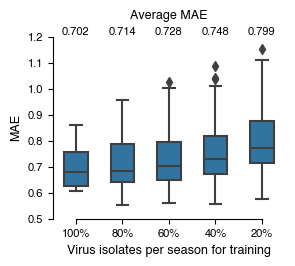

In [8]:
fig, ax = plt.subplots(figsize=(3,2.4))

plot = sns.boxplot(x='isolates_train', y='MAE', data=scores[scores.season!='Average'],
                   width=0.5,
                   color="C0",
                   ax=ax)

# annotate
# convert isolates_train from string with percent sign to float
scores['isolates_train'] = scores.isolates_train.str.rstrip('%').astype('int')
avg_MAE                  = scores[scores.season=='Average'].groupby(['isolates_train']).mean().MAE.sort_index(ascending=False)
for (xtick, label) in zip(plot.get_xticks(), avg_MAE):
    ax.text(xtick,
            1.21,
            f"{label:.3f}",
            horizontalalignment='center',
            fontsize=8,
            rotation=0)

ax.text(2, 1.27, "Average MAE", fontsize=9, horizontalalignment='center')


ax.set_xlabel('Virus isolates per season for training', fontsize=9)
ax.set_ylabel('MAE', fontsize=9)
ax.set_ylim(bottom=0.5, top=1.21)

sns.despine(trim=True)

# save figure
fig.savefig(fig_fn, format='svg', bbox_inches='tight')